In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# To supress warnings
import warnings

warnings.filterwarnings("ignore")



In [2]:

!pip install missingno

import warnings
warnings.simplefilter(action="ignore")

In [3]:
file_path = "NAFLD.xlsx"  # İndirilen dosyanın yolu
df = pd.read_excel(file_path)

In [4]:

def check_df(dataframe, head=5):
 print("##################### SHAPE ##################")
 print(dataframe.shape)
 print("##################### TYPES ##################")
 print(dataframe.dtypes)
 print("##################### HEAD ##################")
 print(dataframe.head(head))
 print("##################### TAIL ##################")
 print(dataframe.tail(head))
 print("##################### NA ##################")
 print(dataframe.isnull().sum())
 print("##################### QUANTILES ##################")
 print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
 check_df(df)

##################### SHAPE ##################
(605, 62)
##################### TYPES ##################
Patient No.                                                                                    int64
Age                                                                                            int64
Gender (Female=1, Male=2)                                                                      int64
Height                                                                                         int64
Weight                                                                                         int64
                                                                                               ...  
Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)    int64
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)       int64
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)                          

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

 cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]


 num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]

 cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

 cat_cols = cat_cols + num_but_cat
 cat_cols = [col for col in cat_cols if col not in cat_but_car]

# Num_cols

 num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
 num_cols = [col for col in num_cols if col not in num_but_cat]

 print(f"Observations: {dataframe.shape[0]}")
 print(f"Variables: {dataframe.shape[1]}")
 print(f'cat_cols: {len(cat_cols)}')
 print(f'num_cols: {len(num_cols)}')
 print(f'cat_but_car: {len(cat_but_car)}')
 print(f'num_but_cat: {len(num_but_cat)}')

 return cat_cols, num_cols, cat_but_car



In [7]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

cat_cols
num_cols
cat_but_car

Observations: 605
Variables: 62
cat_cols: 18
num_cols: 44
cat_but_car: 0
num_but_cat: 18


[]

In [8]:
def cat_summary(dataframe, col_name, plot=False):
 print(pd.DataFrame({col_name: dataframe[col_name].value_counts(), "Ratio":100 * dataframe[col_name].value_counts() / len(dataframe)}))
 print("#######################################################################################")
 if plot:
  sns.countplot(x=dataframe[col_name], data=dataframe)
  plt.show()

 

In [9]:
cat_summary(df, "Diagnosis according to SAF (NASH=1, NAFL=2)")

   Diagnosis according to SAF (NASH=1, NAFL=2)      Ratio
1                                          537  88.760331
2                                           68  11.239669
#######################################################################################


In [10]:
########## numerik değişkenlerin analizi:

def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
   dataframe[numerical_col].hist(bins=20)
   plt.xlabel(numerical_col)
   plt.title(numerical_col)
   plt.show()

 


count    605.000000
mean     303.000000
std      174.792734
min        1.000000
5%        31.200000
10%       61.400000
20%      121.800000
30%      182.200000
40%      242.600000
50%      303.000000
60%      363.400000
70%      423.800000
80%      484.200000
90%      544.600000
95%      574.800000
99%      598.960000
max      605.000000
Name: Patient No., dtype: float64


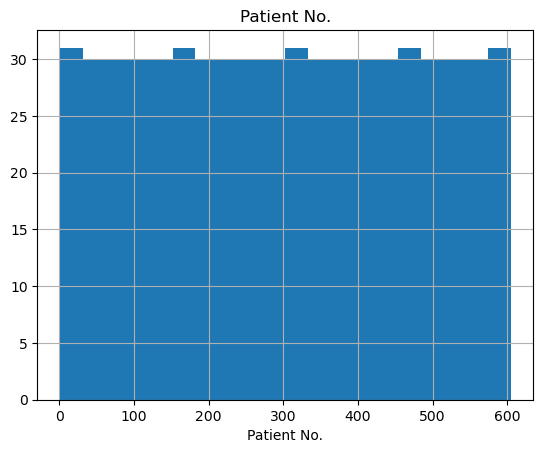

count    605.000000
mean      46.302479
std       10.646148
min       18.000000
5%        29.000000
10%       32.000000
20%       36.000000
30%       40.000000
40%       44.000000
50%       47.000000
60%       50.000000
70%       53.000000
80%       56.000000
90%       59.000000
95%       62.800000
99%       68.000000
max       71.000000
Name: Age, dtype: float64


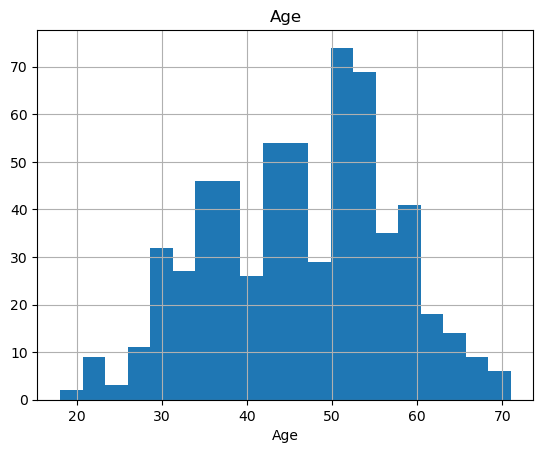

count    605.000000
mean     164.790083
std        9.920240
min      135.000000
5%       150.000000
10%      151.000000
20%      155.000000
30%      158.000000
40%      162.000000
50%      165.000000
60%      169.000000
70%      171.000000
80%      174.000000
90%      177.600000
95%      180.000000
99%      185.000000
max      193.000000
Name: Height, dtype: float64


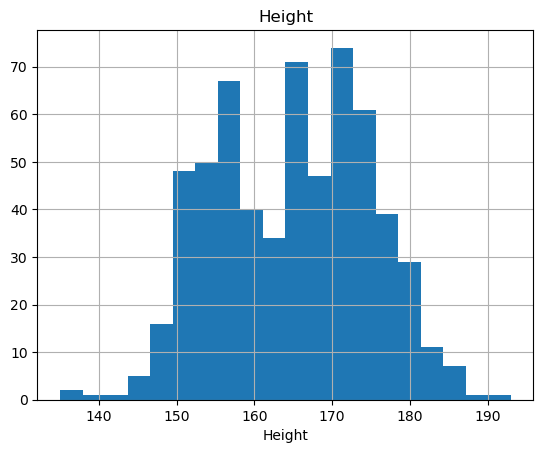

count    605.000000
mean      86.403306
std       14.379183
min       48.000000
5%        65.000000
10%       69.000000
20%       74.800000
30%       79.000000
40%       83.000000
50%       85.000000
60%       89.400000
70%       92.000000
80%       97.000000
90%      104.000000
95%      111.000000
99%      126.000000
max      158.000000
Name: Weight, dtype: float64


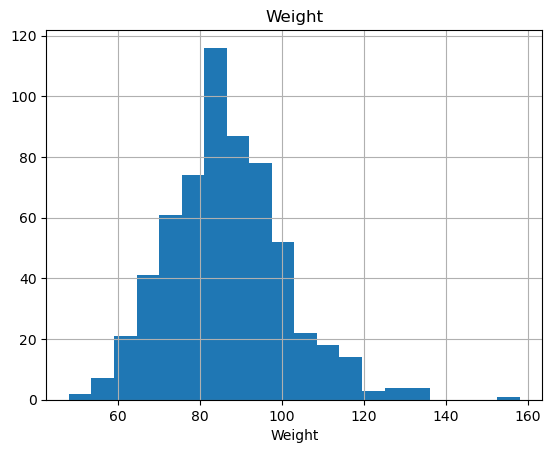

count    605.000000
mean      31.868711
std        5.106853
min       18.290000
5%        24.610000
10%       25.926000
20%       27.874000
30%       29.040000
40%       30.236000
50%       31.210000
60%       32.398000
70%       33.778000
80%       35.494000
90%       38.538000
95%       40.786000
99%       48.208800
max       56.000000
Name: Body Mass Index, dtype: float64


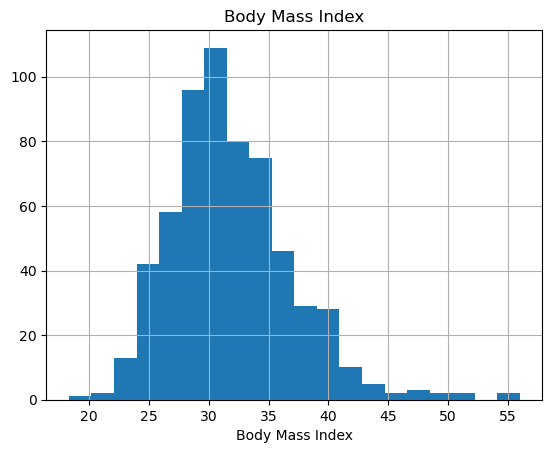

count    576.000000
mean     109.440972
std       10.588755
min       63.000000
5%        95.000000
10%       98.000000
20%      101.000000
30%      104.000000
40%      106.000000
50%      108.000000
60%      110.000000
70%      114.000000
80%      116.000000
90%      122.500000
95%      127.000000
99%      142.500000
max      155.000000
Name: Waist Circumference, dtype: float64


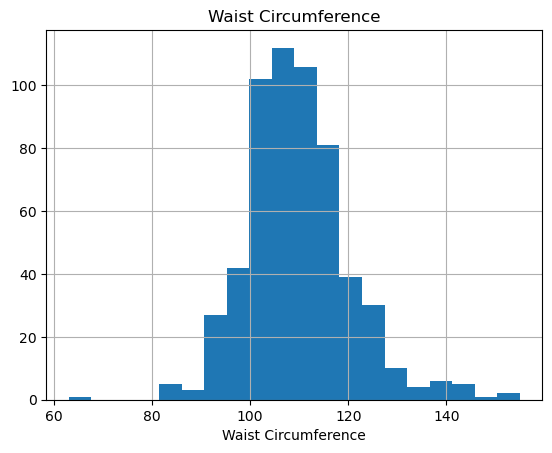

count    598.000000
mean     104.306020
std       10.385775
min       70.000000
5%        89.000000
10%       91.000000
20%       95.000000
30%       99.000000
40%      102.000000
50%      104.000000
60%      106.000000
70%      109.000000
80%      112.000000
90%      117.000000
95%      122.000000
99%      130.030000
max      147.000000
Name: Hip Circumference, dtype: float64


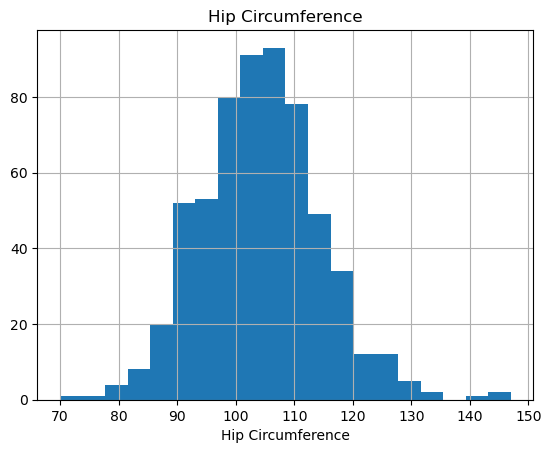

count    605.000000
mean     127.276033
std       15.314631
min       90.000000
5%       110.000000
10%      110.000000
20%      120.000000
30%      120.000000
40%      120.000000
50%      121.000000
60%      130.000000
70%      130.000000
80%      140.000000
90%      150.000000
95%      160.000000
99%      179.880000
max      190.000000
Name: Systolic Blood Pressure, dtype: float64


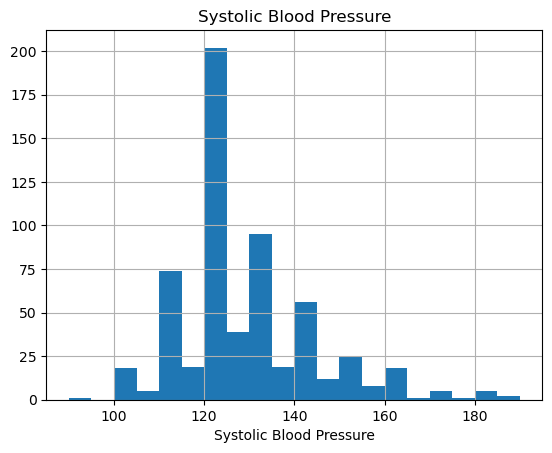

count    605.000000
mean      82.423140
std        9.941857
min       51.000000
5%        70.000000
10%       70.000000
20%       75.000000
30%       80.000000
40%       80.000000
50%       80.000000
60%       80.000000
70%       86.800000
80%       90.000000
90%       95.000000
95%      100.000000
99%      110.000000
max      120.000000
Name: Diastolic Blood Pressure, dtype: float64


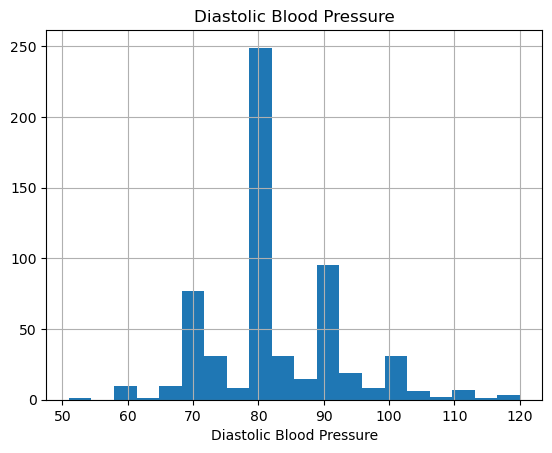

count    605.000000
mean      48.723636
std       30.248332
min       11.000000
5%        21.000000
10%       24.000000
20%       29.000000
30%       33.000000
40%       37.000000
50%       42.000000
60%       46.000000
70%       53.000000
80%       61.200000
90%       77.000000
95%      103.800000
99%      161.760000
max      302.000000
Name: AST, dtype: float64


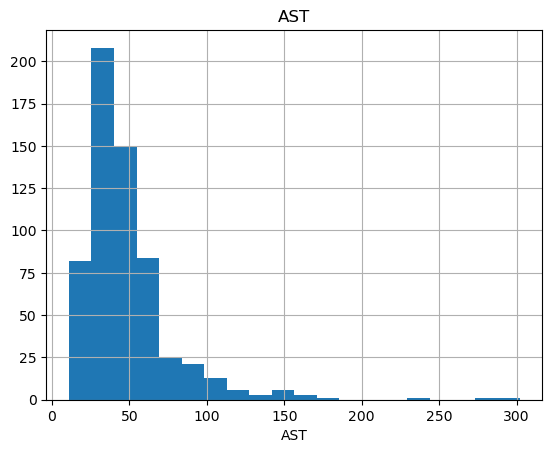

count    605.000000
mean      76.523967
std       49.417114
min       12.000000
5%        21.200000
10%       28.000000
20%       38.000000
30%       48.000000
40%       57.000000
50%       66.000000
60%       77.000000
70%       89.000000
80%      106.000000
90%      134.600000
95%      174.000000
99%      270.880000
max      343.000000
Name: ALT, dtype: float64


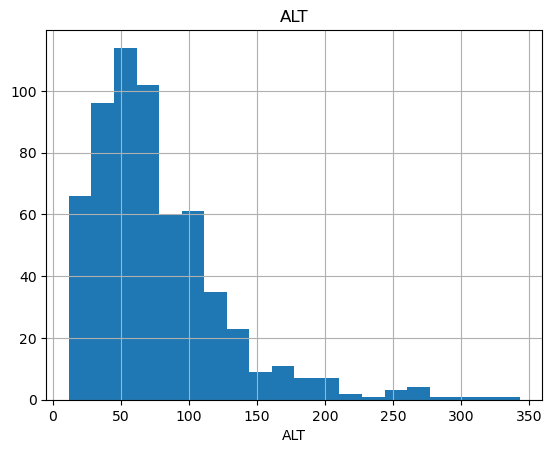

count    604.000000
mean     108.751656
std       66.752193
min       25.000000
5%        53.000000
10%       59.000000
20%       66.000000
30%       75.000000
40%       80.000000
50%       89.500000
60%       97.000000
70%      109.100000
80%      136.000000
90%      186.700000
95%      240.850000
99%      380.940000
max      625.000000
Name: ALP, dtype: float64


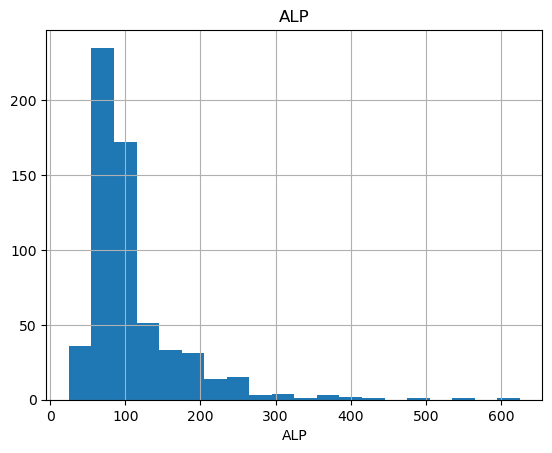

count    602.000000
mean      69.121262
std       68.697753
min        9.000000
5%        19.000000
10%       24.000000
20%       30.000000
30%       37.000000
40%       43.000000
50%       49.000000
60%       57.000000
70%       69.000000
80%       86.000000
90%      128.900000
95%      179.950000
99%      429.120000
max      559.000000
Name: GGT, dtype: float64


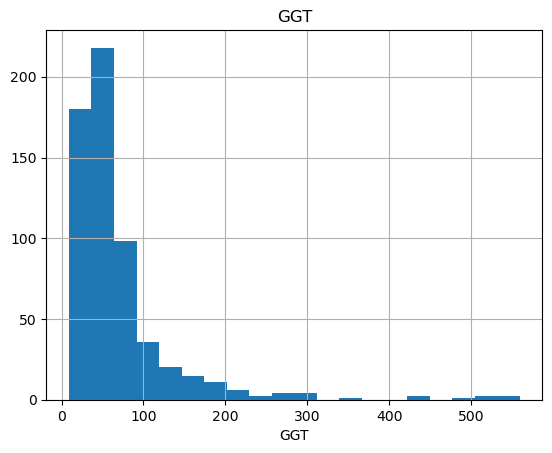

count    561.000000
mean     249.231729
std       94.306282
min       19.000000
5%       161.000000
10%      169.000000
20%      182.000000
30%      193.000000
40%      203.000000
50%      216.000000
60%      233.000000
70%      266.000000
80%      317.000000
90%      380.000000
95%      421.000000
99%      537.600000
max      969.000000
Name: LDH, dtype: float64


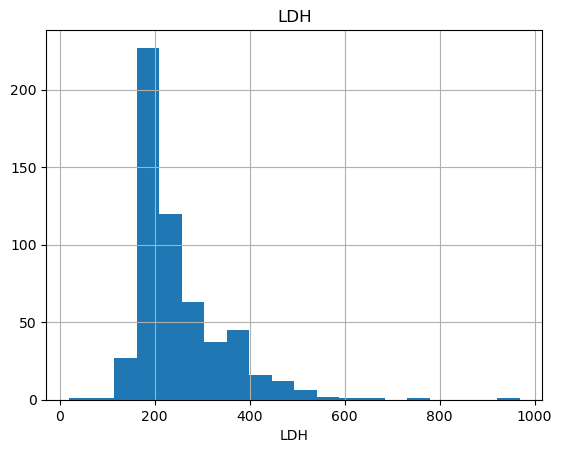

count    604.000000
mean       0.796904
std        0.601195
min        0.050000
5%         0.321500
10%        0.390000
20%        0.480000
30%        0.540000
40%        0.600000
50%        0.655000
60%        0.738000
70%        0.830000
80%        0.970000
90%        1.210000
95%        1.600000
99%        2.877600
max        7.600000
Name: Total Bilirubin, dtype: float64


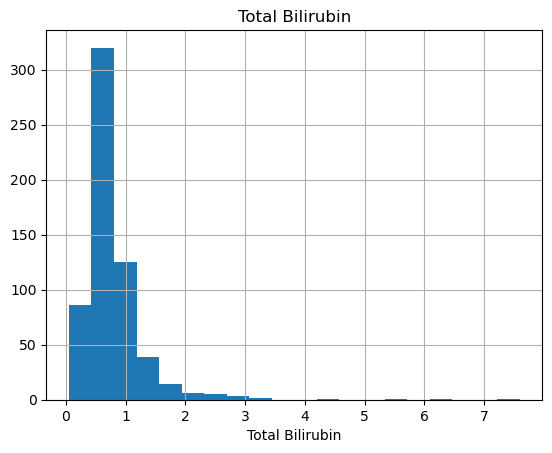

count    604.000000
mean       0.210000
std        0.167827
min        0.010000
5%         0.070000
10%        0.090000
20%        0.110000
30%        0.130000
40%        0.140000
50%        0.170000
60%        0.200000
70%        0.220000
80%        0.260000
90%        0.350000
95%        0.494000
99%        0.899400
max        1.830000
Name: Direct Bilirubin, dtype: float64


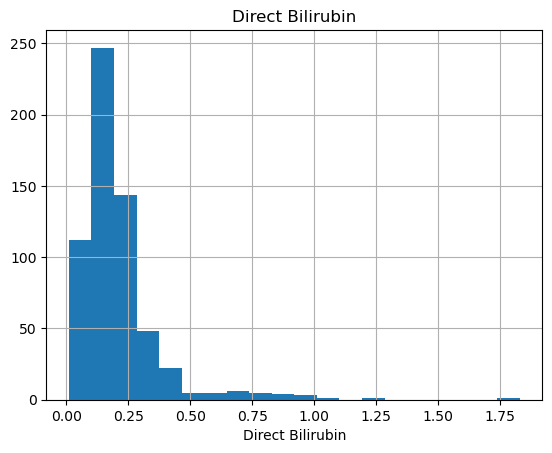

count    523.000000
mean       7.782409
std        0.459265
min        6.400000
5%         7.100000
10%        7.200000
20%        7.400000
30%        7.500000
40%        7.700000
50%        7.800000
60%        7.900000
70%        8.000000
80%        8.200000
90%        8.316000
95%        8.500000
99%        9.000000
max        9.140000
Name: Total Protein, dtype: float64


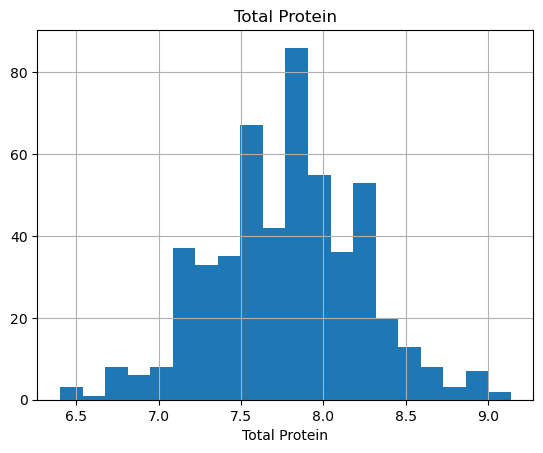

count    605.000000
mean       4.670397
std        0.378629
min        3.400000
5%         4.000000
10%        4.200000
20%        4.400000
30%        4.500000
40%        4.600000
50%        4.700000
60%        4.800000
70%        4.900000
80%        5.000000
90%        5.100000
95%        5.210000
99%        5.500000
max        5.900000
Name: Albumin, dtype: float64


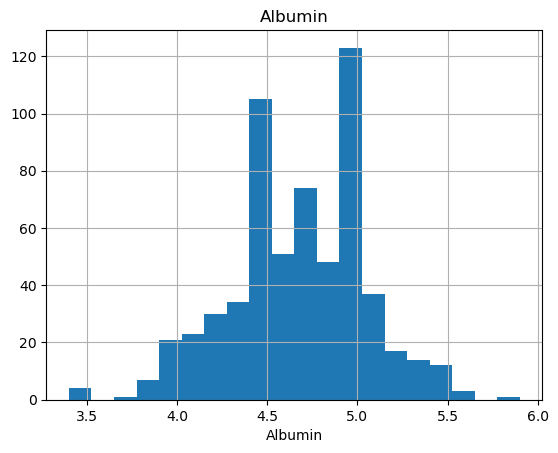

count    605.000000
mean     209.702479
std       48.394804
min       74.000000
5%       128.000000
10%      150.000000
20%      172.800000
30%      187.000000
40%      200.000000
50%      211.000000
60%      220.000000
70%      232.000000
80%      247.000000
90%      266.000000
95%      284.800000
99%      349.440000
max      419.000000
Name: Total Cholesterol, dtype: float64


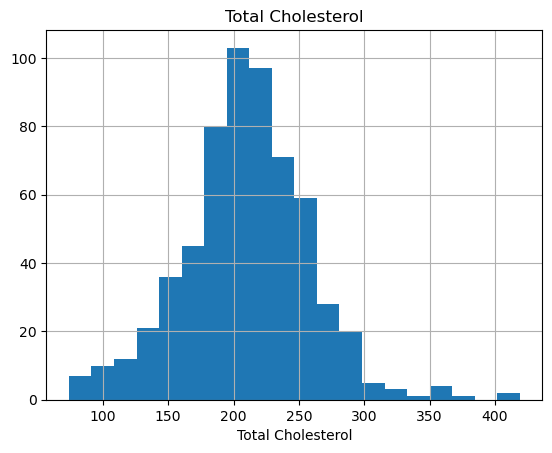

count     604.000000
mean      190.847682
std       114.889694
min        37.000000
5%         69.150000
10%        85.600000
20%       108.000000
30%       123.900000
40%       148.000000
50%       164.500000
60%       192.000000
70%       217.000000
80%       255.200000
90%       311.700000
95%       397.700000
99%       566.580000
max      1107.000000
Name: Triglycerides, dtype: float64


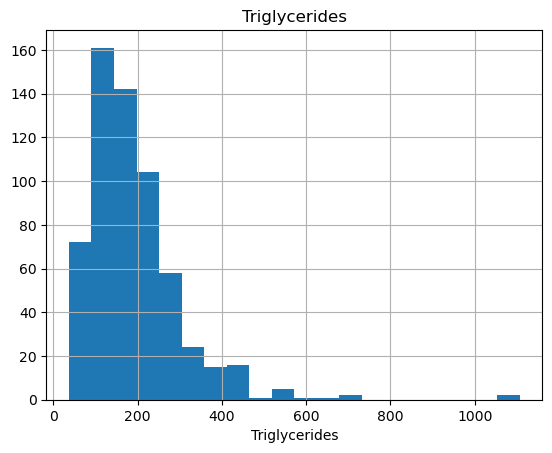

count    604.000000
mean      45.390132
std       10.544145
min       18.000000
5%        30.000000
10%       34.000000
20%       37.000000
30%       40.000000
40%       42.000000
50%       44.000000
60%       46.000000
70%       49.000000
80%       53.000000
90%       59.000000
95%       64.000000
99%       76.940000
max       96.000000
Name: HDL, dtype: float64


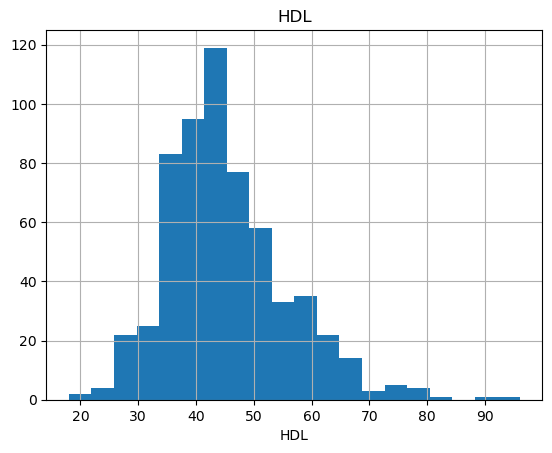

count    602.000000
mean     133.946844
std       42.796921
min       28.000000
5%        71.000000
10%       83.000000
20%      101.200000
30%      114.000000
40%      124.000000
50%      134.000000
60%      144.000000
70%      153.000000
80%      163.000000
90%      182.000000
95%      193.950000
99%      258.740000
max      400.000000
Name: LDL, dtype: float64


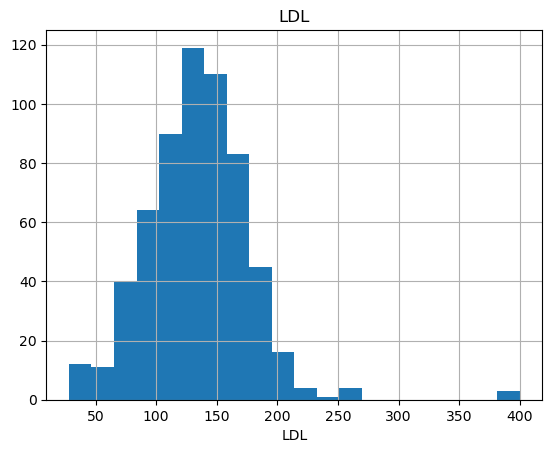

count     183.000000
mean       73.397650
std       271.572954
min         0.000000
5%          0.800000
10%         1.620000
20%         3.394000
30%         5.466000
40%         8.846000
50%        11.540000
60%        15.588000
70%        22.946000
80%        33.624000
90%        93.928000
95%       371.644000
99%       881.700000
max      2925.010000
Name: Microalbumin Spot Urine, dtype: float64


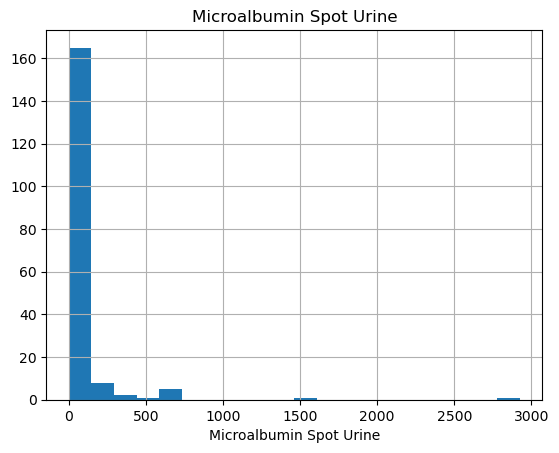

count     115.000000
mean       93.039130
std       444.777009
min         0.750000
5%          2.064000
10%         2.722000
20%         4.554000
30%         5.554000
40%         6.766000
50%         9.460000
60%        12.506000
70%        17.536000
80%        29.610000
90%        79.248000
95%       326.560000
99%      1008.466800
max      4472.000000
Name: Microalbumin/Creatinine Ratio, dtype: float64


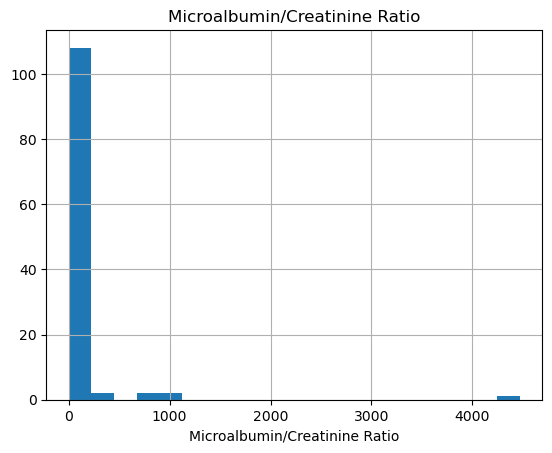

count    293.00000
mean       1.87843
std        1.34420
min        0.02000
5%         0.51600
10%        0.66000
20%        0.95400
30%        1.11600
40%        1.33800
50%        1.54000
60%        1.84000
70%        2.16800
80%        2.63000
90%        3.32600
95%        4.32800
99%        5.77480
max       13.30000
Name: TSH, dtype: float64


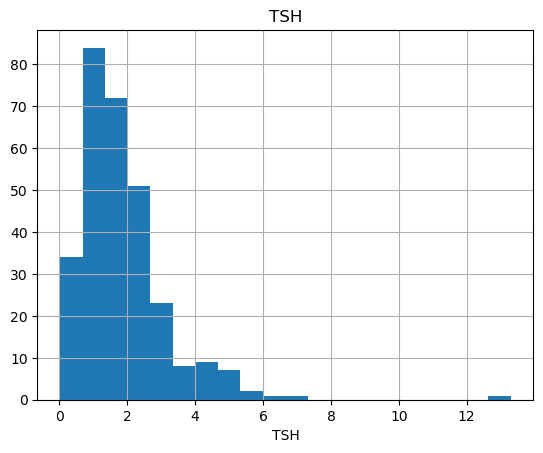

count    153.000000
mean     136.315817
std       99.792323
min        0.720000
5%        51.600000
10%       59.000000
20%       69.400000
30%       82.000000
40%       96.000000
50%      110.000000
60%      128.600000
70%      150.400000
80%      191.000000
90%      241.000000
95%      267.400000
99%      549.680000
max      773.000000
Name: CK, dtype: float64


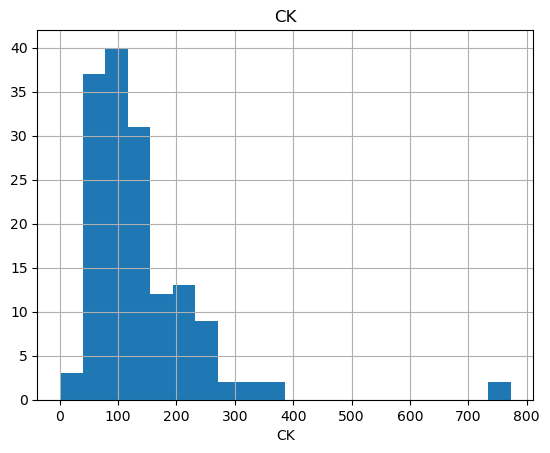

count      604.000000
mean      7248.725166
std       1899.582794
min       2400.000000
5%        4700.000000
10%       5000.000000
20%       5600.000000
30%       6100.000000
40%       6600.000000
50%       7000.000000
60%       7500.000000
70%       8000.000000
80%       8800.000000
90%       9800.000000
95%      10717.000000
99%      12300.000000
max      14900.000000
Name: Leukocyte, dtype: float64


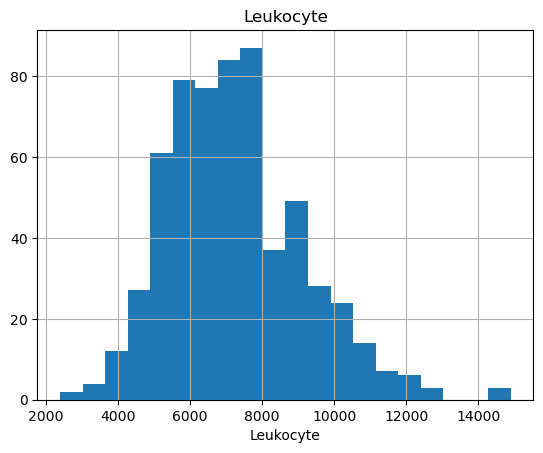

count    604.000000
mean      14.318675
std        1.712394
min        7.100000
5%        11.400000
10%       12.100000
20%       13.000000
30%       13.600000
40%       14.000000
50%       14.400000
60%       14.900000
70%       15.300000
80%       15.700000
90%       16.300000
95%       16.870000
99%       17.597000
max       18.900000
Name: Hemoglobin, dtype: float64


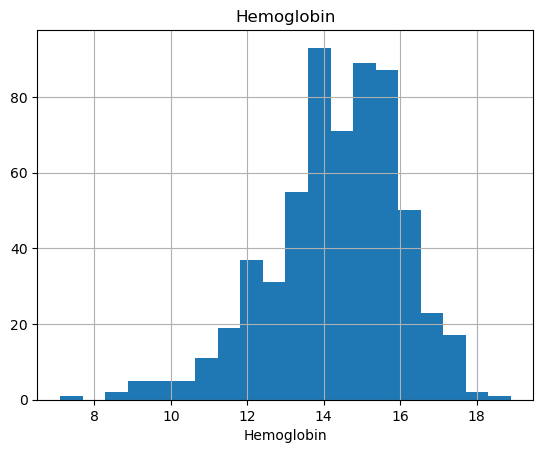

count    604.000000
mean     241.925497
std       67.999971
min       77.000000
5%       127.450000
10%      159.000000
20%      187.600000
30%      206.800000
40%      224.200000
50%      240.000000
60%      253.000000
70%      270.000000
80%      292.000000
90%      329.700000
95%      364.700000
99%      423.910000
max      543.000000
Name: Trombosit, dtype: float64


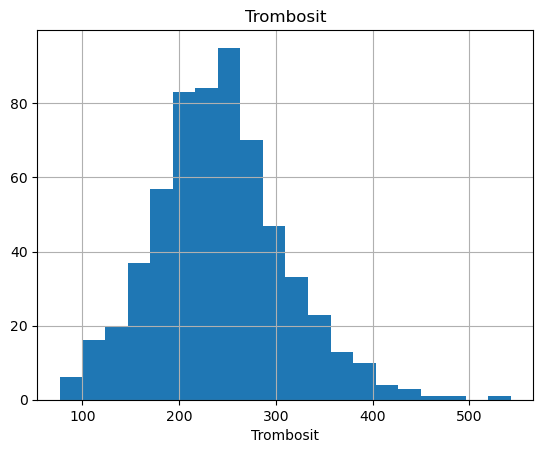

count    603.000000
mean      85.488723
std        7.243531
min       13.100000
5%        75.620000
10%       79.720000
20%       82.400000
30%       83.760000
40%       85.100000
50%       86.000000
60%       87.500000
70%       88.440000
80%       90.000000
90%       92.000000
95%       94.000000
99%       95.988000
max      100.700000
Name: Mean Corpuscular Volume, dtype: float64


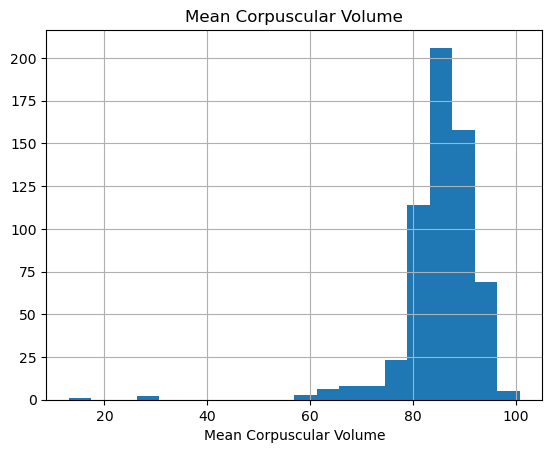

count    591.000000
mean       8.790068
std        1.291252
min        5.620000
5%         7.105000
10%        7.400000
20%        7.800000
30%        8.150000
40%        8.400000
50%        8.600000
60%        8.900000
70%        9.200000
80%        9.600000
90%       10.200000
95%       10.800000
99%       12.560000
max       18.000000
Name: Mean Platelet Volume, dtype: float64


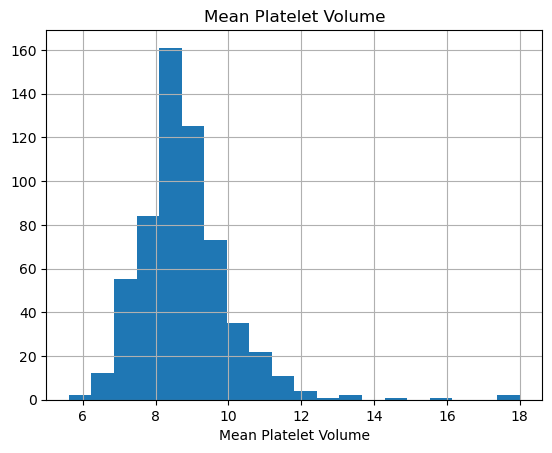

count    237.000000
mean      12.981899
std        1.088528
min        7.500000
5%        11.200000
10%       11.700000
20%       12.300000
30%       12.500000
40%       12.800000
50%       13.000000
60%       13.200000
70%       13.400000
80%       13.700000
90%       14.200000
95%       14.720000
99%       15.864000
max       16.600000
Name: PT, dtype: float64


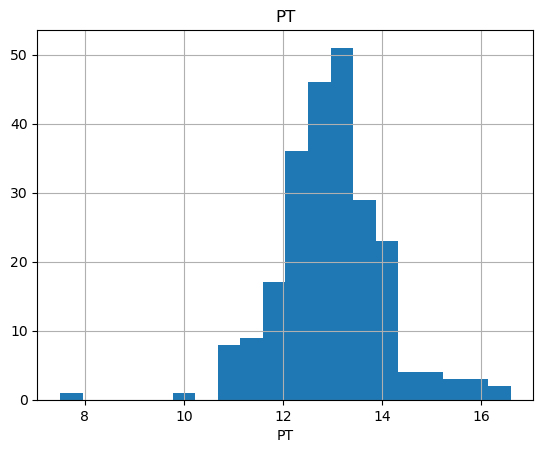

count    304.000000
mean       1.040625
std        0.157356
min        0.190000
5%         0.891500
10%        0.900000
20%        0.940000
30%        0.990000
40%        1.000000
50%        1.020000
60%        1.038000
70%        1.060000
80%        1.100000
90%        1.180000
95%        1.300000
99%        1.700000
max        1.900000
Name: INR, dtype: float64


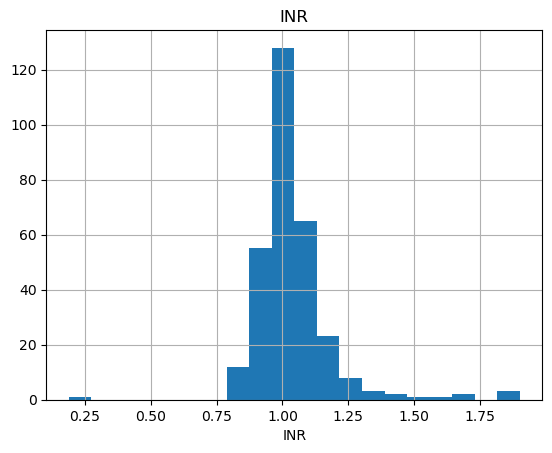

count    193.000000
mean      22.682953
std       11.361046
min        6.180000
5%         9.280000
10%       11.280000
20%       14.138000
30%       15.976000
40%       17.590000
50%       20.450000
60%       22.402000
70%       25.946000
80%       29.862000
90%       36.000000
95%       44.084000
99%       62.167200
max       66.000000
Name: Vitamin D, dtype: float64


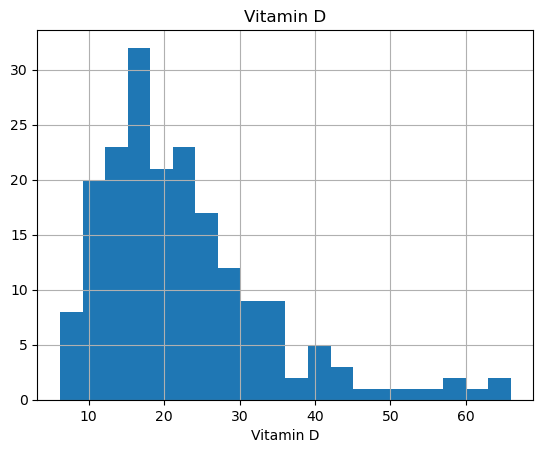

count    588.000000
mean     129.078197
std      121.494924
min        3.800000
5%        11.410000
10%       20.000000
20%       37.000000
30%       53.000000
40%       73.080000
50%       91.100000
60%      115.200000
70%      151.700000
80%      211.000000
90%      281.300000
95%      368.650000
99%      555.839000
max      821.200000
Name: Ferritin, dtype: float64


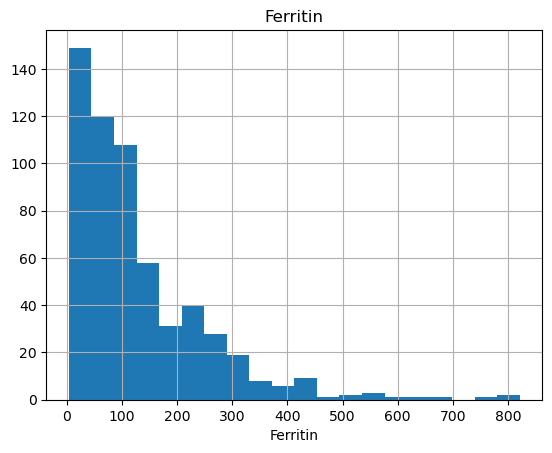

count    288.000000
mean       0.285139
std        0.074991
min        0.110000
5%         0.200000
10%        0.210000
20%        0.230000
30%        0.250000
40%        0.260000
50%        0.280000
60%        0.290000
70%        0.310000
80%        0.326000
90%        0.370000
95%        0.400000
99%        0.513000
max        0.730000
Name: Ceruloplasmin, dtype: float64


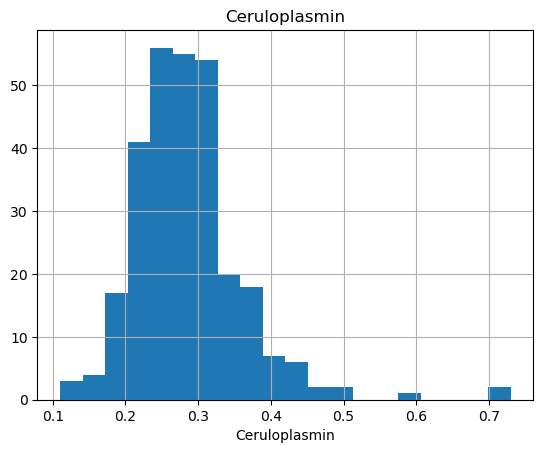

count    167.000000
mean       3.776467
std        1.550389
min        1.080000
5%         1.892000
10%        2.250000
20%        2.684000
30%        2.986000
40%        3.188000
50%        3.430000
60%        3.824000
70%        4.232000
80%        4.604000
90%        5.370000
95%        6.460000
99%        9.493800
max       10.900000
Name: C Peptide, dtype: float64


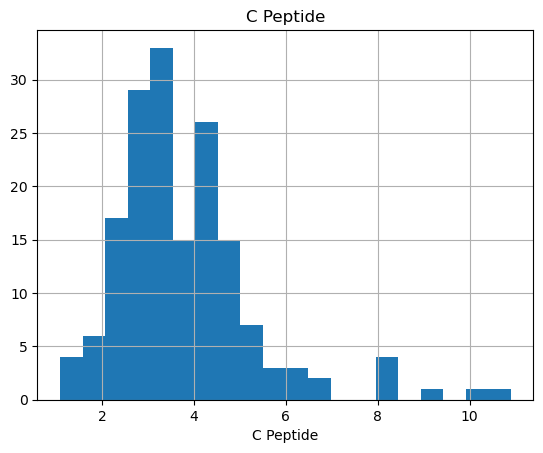

count    601.000000
mean     108.845258
std       30.863263
min       66.000000
5%        79.000000
10%       84.000000
20%       90.000000
30%       94.000000
40%       97.000000
50%      100.000000
60%      105.000000
70%      112.000000
80%      122.000000
90%      139.000000
95%      170.000000
99%      240.000000
max      307.000000
Name: Glucose, dtype: float64


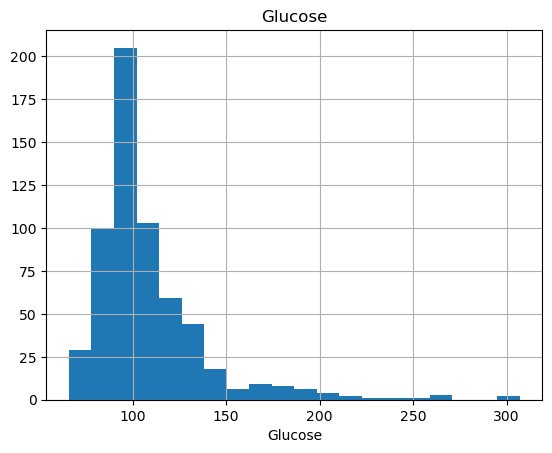

count    277.000000
mean      18.692022
std       11.475016
min        1.850000
5%         5.848000
10%        8.000000
20%       10.830000
30%       12.180000
40%       13.820000
50%       16.000000
60%       17.584000
70%       20.302000
80%       25.748000
90%       33.828000
95%       44.650000
99%       56.423200
max       76.120000
Name: Insulin, dtype: float64


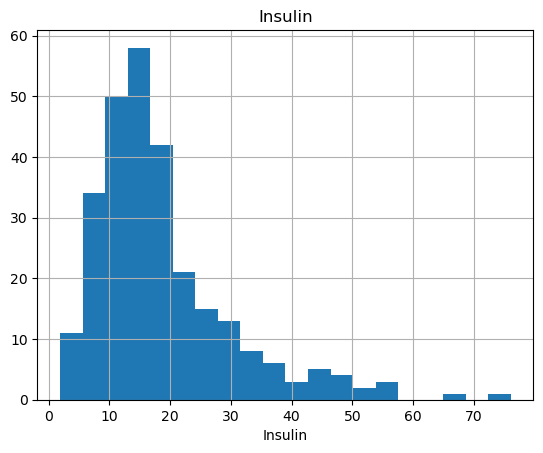

count    277.000000
mean       5.285235
std        4.063863
min        0.320000
5%         1.402000
10%        1.844000
20%        2.452000
30%        3.108000
40%        3.464000
50%        4.020000
60%        4.596000
70%        5.528000
80%        7.456000
90%       11.060000
95%       13.286000
99%       18.866000
max       28.760000
Name: HOMA, dtype: float64


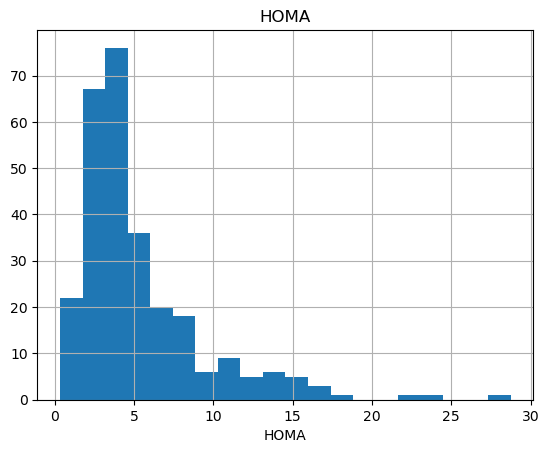

count    254.000000
mean       6.179213
std        1.464421
min        0.700000
5%         3.880000
10%        4.318000
20%        5.100000
30%        5.379000
40%        5.776000
50%        6.200000
60%        6.594000
70%        7.030000
80%        7.400000
90%        7.988000
95%        8.459500
99%        9.063400
max       11.070000
Name: Uric Acid, dtype: float64


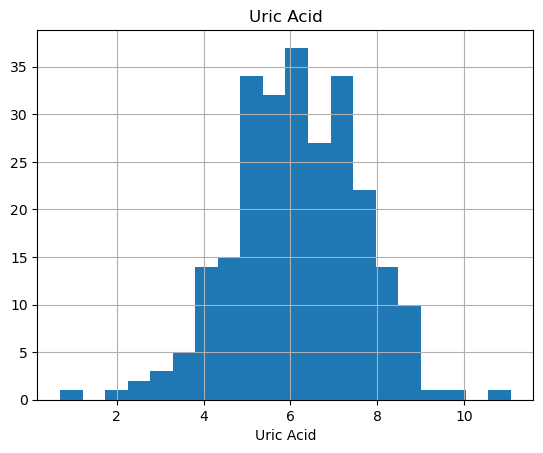

count    305.000000
mean      17.998000
std        7.706472
min        6.000000
5%         9.058000
10%       10.400000
20%       12.000000
30%       13.000000
40%       14.000000
50%       16.000000
60%       17.000000
70%       20.000000
80%       23.200000
90%       29.600000
95%       34.600000
99%       41.000000
max       51.000000
Name: BUN, dtype: float64


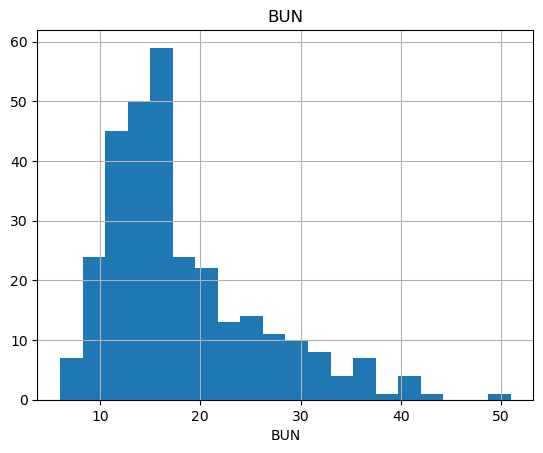

count    305.000000
mean       0.820721
std        0.199360
min        0.410000
5%         0.522000
10%        0.570000
20%        0.640000
30%        0.702000
40%        0.770000
50%        0.820000
60%        0.864000
70%        0.920000
80%        0.992000
90%        1.080000
95%        1.120000
99%        1.200000
max        2.130000
Name: Creatinine, dtype: float64


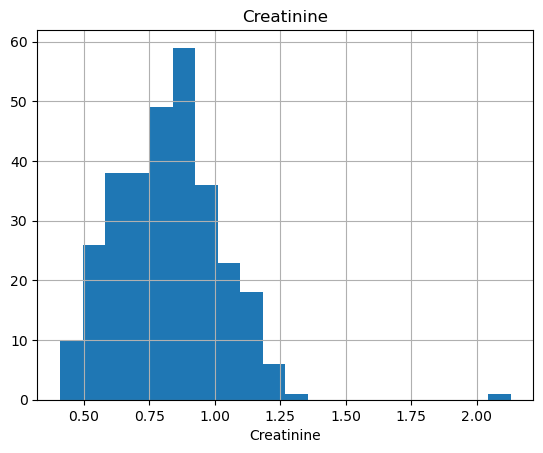

count    564.000000
mean       6.015798
std        1.009040
min        3.520000
5%         4.873000
10%        5.043000
20%        5.334000
30%        5.500000
40%        5.600000
50%        5.800000
60%        6.000000
70%        6.200000
80%        6.600000
90%        7.300000
95%        7.900000
99%        9.937000
max       11.100000
Name: Hemoglobin - A1C, dtype: float64


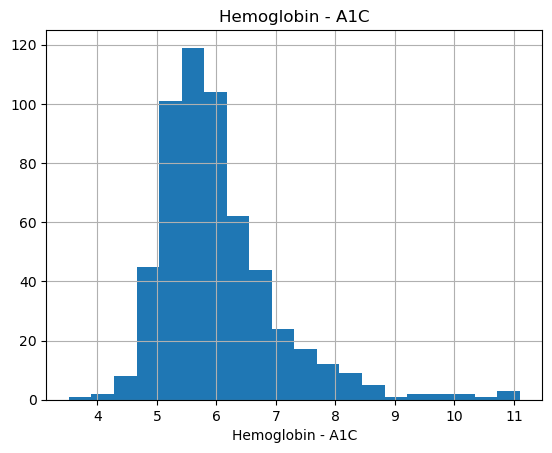

In [11]:
for col in num_cols:
   num_summary(df, col, plot=True)

In [12]:
### numerik değişkenlerin target'a göre analizi...

def target_summary_with_num(dataframe, target, numerical_col):
   print(dataframe.groupby(target).agg({numerical_col:"mean"}), end="\n\n\n")



In [13]:
 for col in num_cols:
  target_summary_with_num(df, "Diagnosis according to SAF (NASH=1, NAFL=2)", col)

                                             Patient No.
Diagnosis according to SAF (NASH=1, NAFL=2)             
1                                             294.642458
2                                             369.000000


                                                   Age
Diagnosis according to SAF (NASH=1, NAFL=2)           
1                                            46.426443
2                                            45.323529


                                                 Height
Diagnosis according to SAF (NASH=1, NAFL=2)            
1                                            164.692737
2                                            165.558824


                                                Weight
Diagnosis according to SAF (NASH=1, NAFL=2)           
1                                            86.754190
2                                            83.632353


                                             Body Mass Index
Diagnosis according to SAF (NASH=1, NAF

In [14]:
######  ######################################################################33

# KORELASYON:


In [15]:
df.corr()

Patient No.       Age  \
Patient No.                                            1.000000  0.090404   
Age                                                    0.090404  1.000000   
Gender (Female=1, Male=2)                             -0.053193 -0.294882   
Height                                                -0.079053 -0.327083   
Weight                                                -0.031545 -0.117581   
...                                                         ...       ...   
Significant Fibrosis (No=0, Yes=1) (If Fibrosis...    -0.026212  0.236602   
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is...     0.039889  0.229799   
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, ther...     0.074430  0.170957   
Diagnosis according to SAF (NASH=1, NAFL=2)            0.134477 -0.032749   
Type of Disease (Mild illness=1, Severe illness=2)    -0.193260 -0.007413   

                                                    Gender (Female=1, Male=2)  \
Patient No.                                                         -0.053193   
Age                                                                 -0.294882   
Gender (Female=1, Male=2)                                            1.000000   
Height                                                               0.748931   
Weight                                                               0.275368   
...                                                                       ...   
Significant Fibrosis (No=0, Yes=1) (If Fibrosis...                  -0.084056   
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is...                  -0.115050   
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, ther...                  -0.080328   
Diagnosis according to SAF (NASH=1, NAFL=2)                          0.072569   
Type of Disease (Mild illness=1, Severe illness=2)                  -0.063589   

                                                      Height    Weight  \
Patient No.                                        -0.079053 -0.031545   
Age                                                -0.327083 -0.117581   
Gender (Female=1, Male=2)                           0.748931  0.275368   
Height                                              1.000000  0.439802   
Weight                                              0.439802  1.000000   
...                                                      ...       ...   
Significant Fibrosis (No=0, Yes=1) (If Fibrosis... -0.096127  0.083231   
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is... -0.125120  0.075239   
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, ther... -0.038414  0.100981   
Diagnosis according to SAF (NASH=1, NAFL=2)         0.027598 -0.068631   
Type of Disease (Mild illness=1, Severe illness=2) -0.020452  0.079419   

                                                    Body Mass Index  \
Patient No.                                                0.033199   
Age                                                        0.121053   
Gender (Female=1, Male=2)                                 -0.283085   
Height                                                    -0.296724   
Weight                                                     0.719885   
...                                                             ...   
Significant Fibrosis (No=0, Yes=1) (If Fibrosis...         0.151655   
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is...         0.166048   
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, ther...         0.126914   
Diagnosis according to SAF (NASH=1, NAFL=2)               -0.096190   
Type of Disease (Mild illness=1, Severe illness=2)         0.101660   

                                                    Waist Circumference  \
Patient No.                                                    0.002637   
Age                                                            0.100211   
Gender (Female=1, Male=2)                                     -0.329481   
Height                                                        -0.194799   
Weight                               

In [16]:
# korelasyon matrisi:

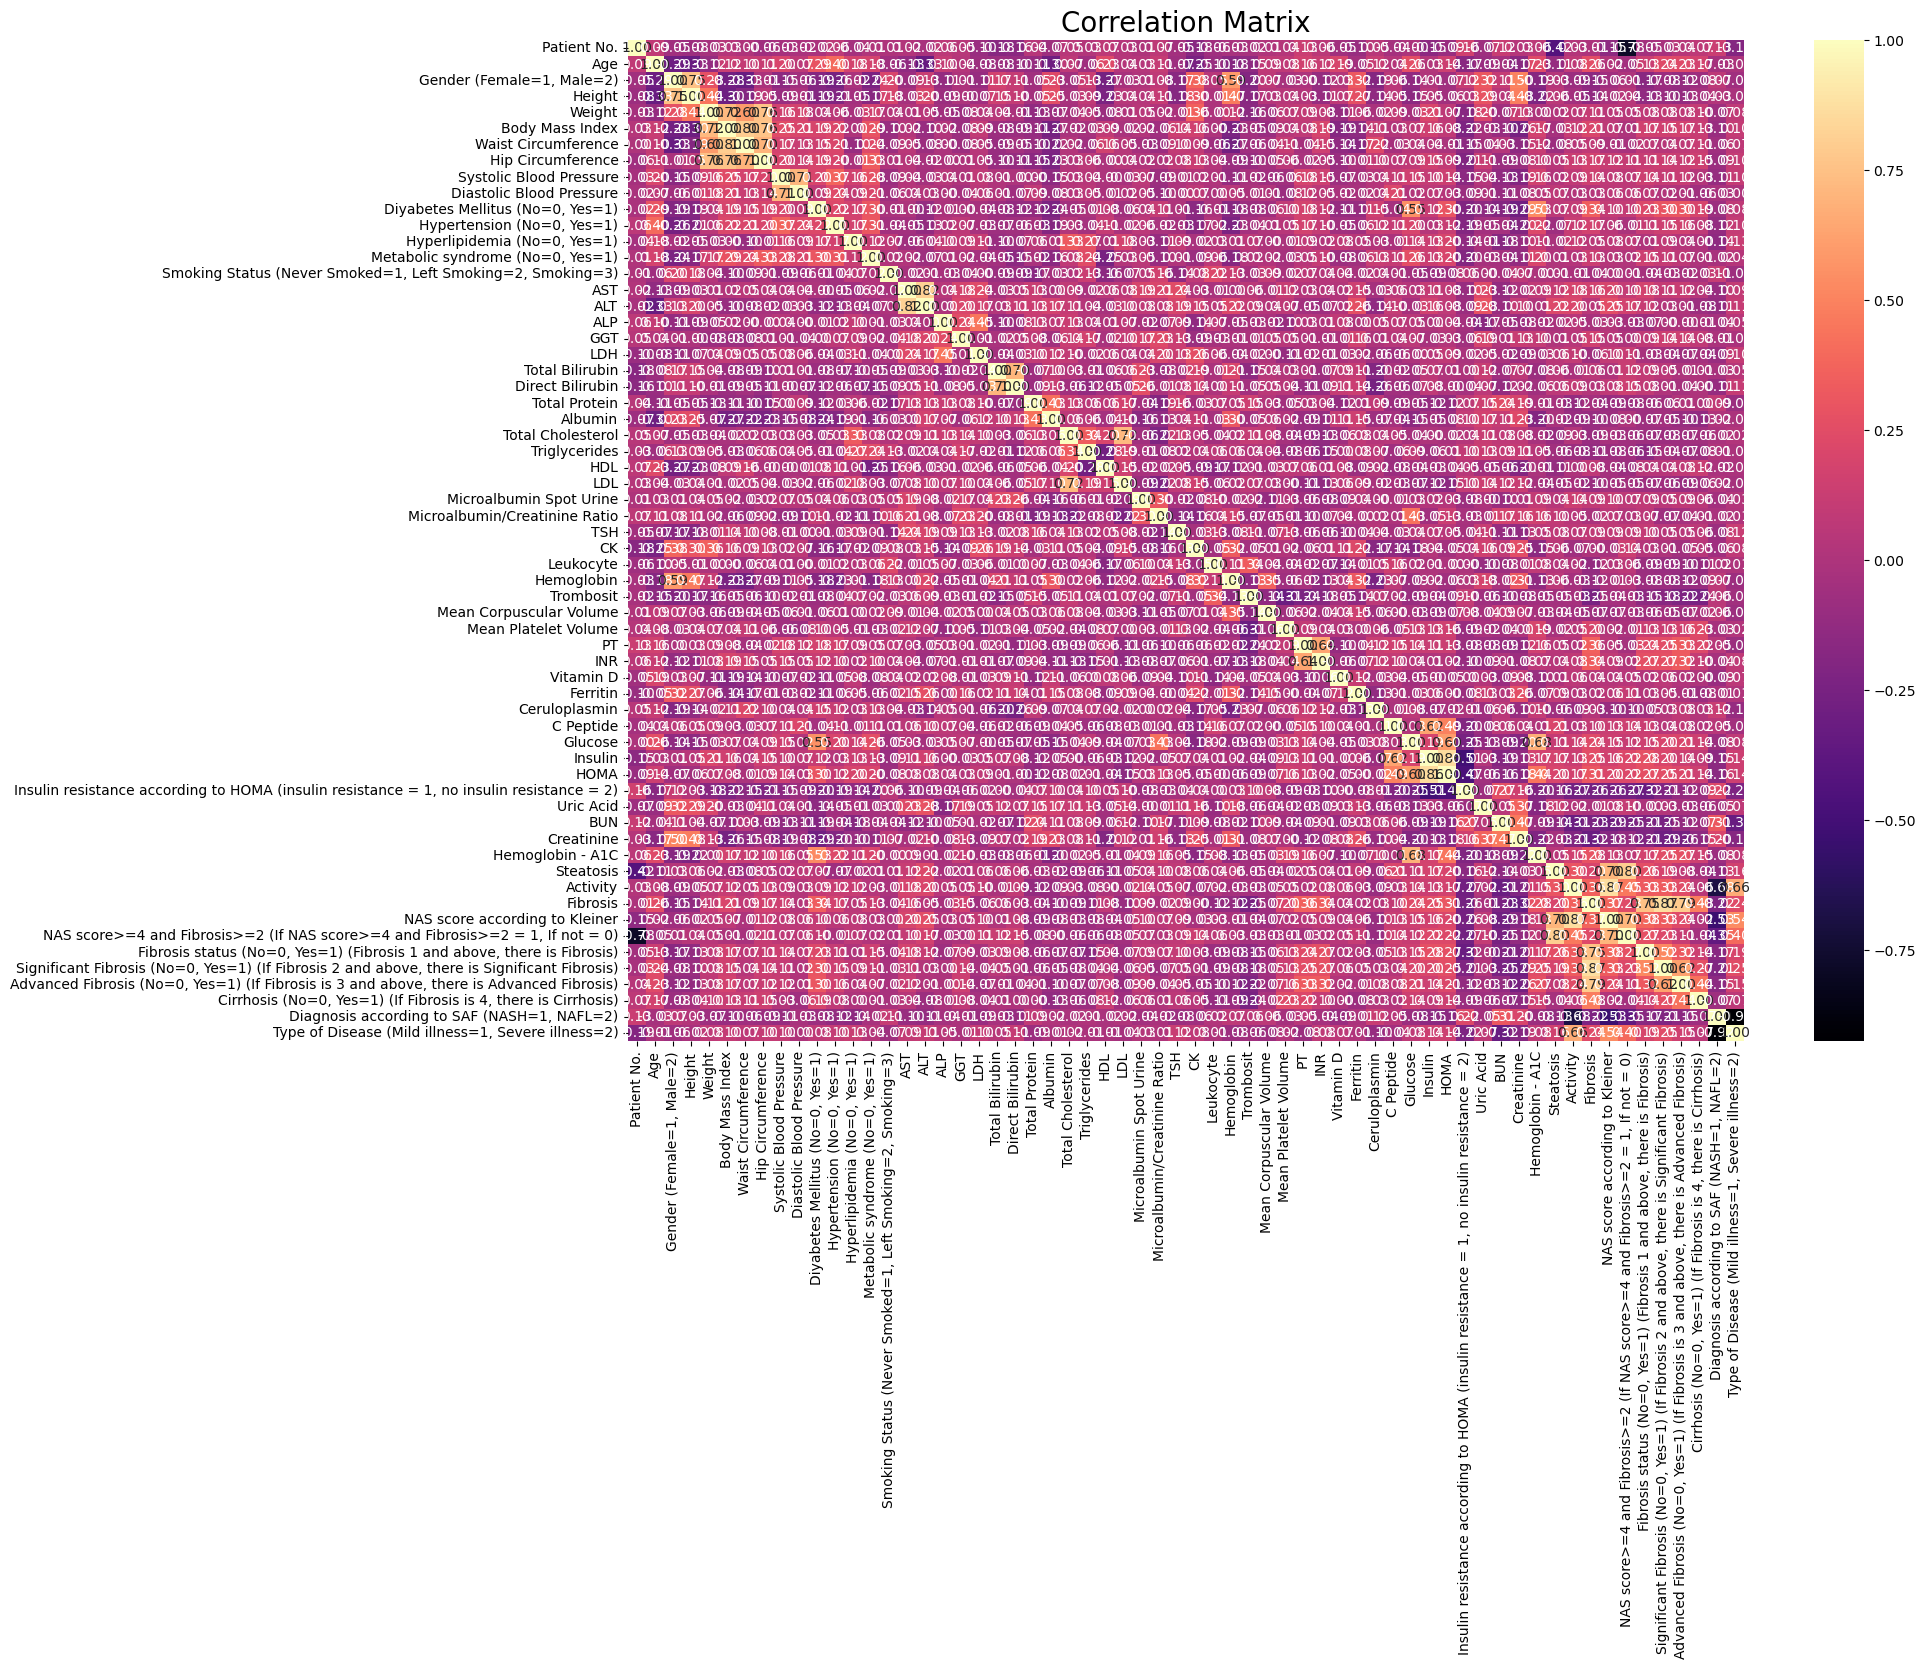

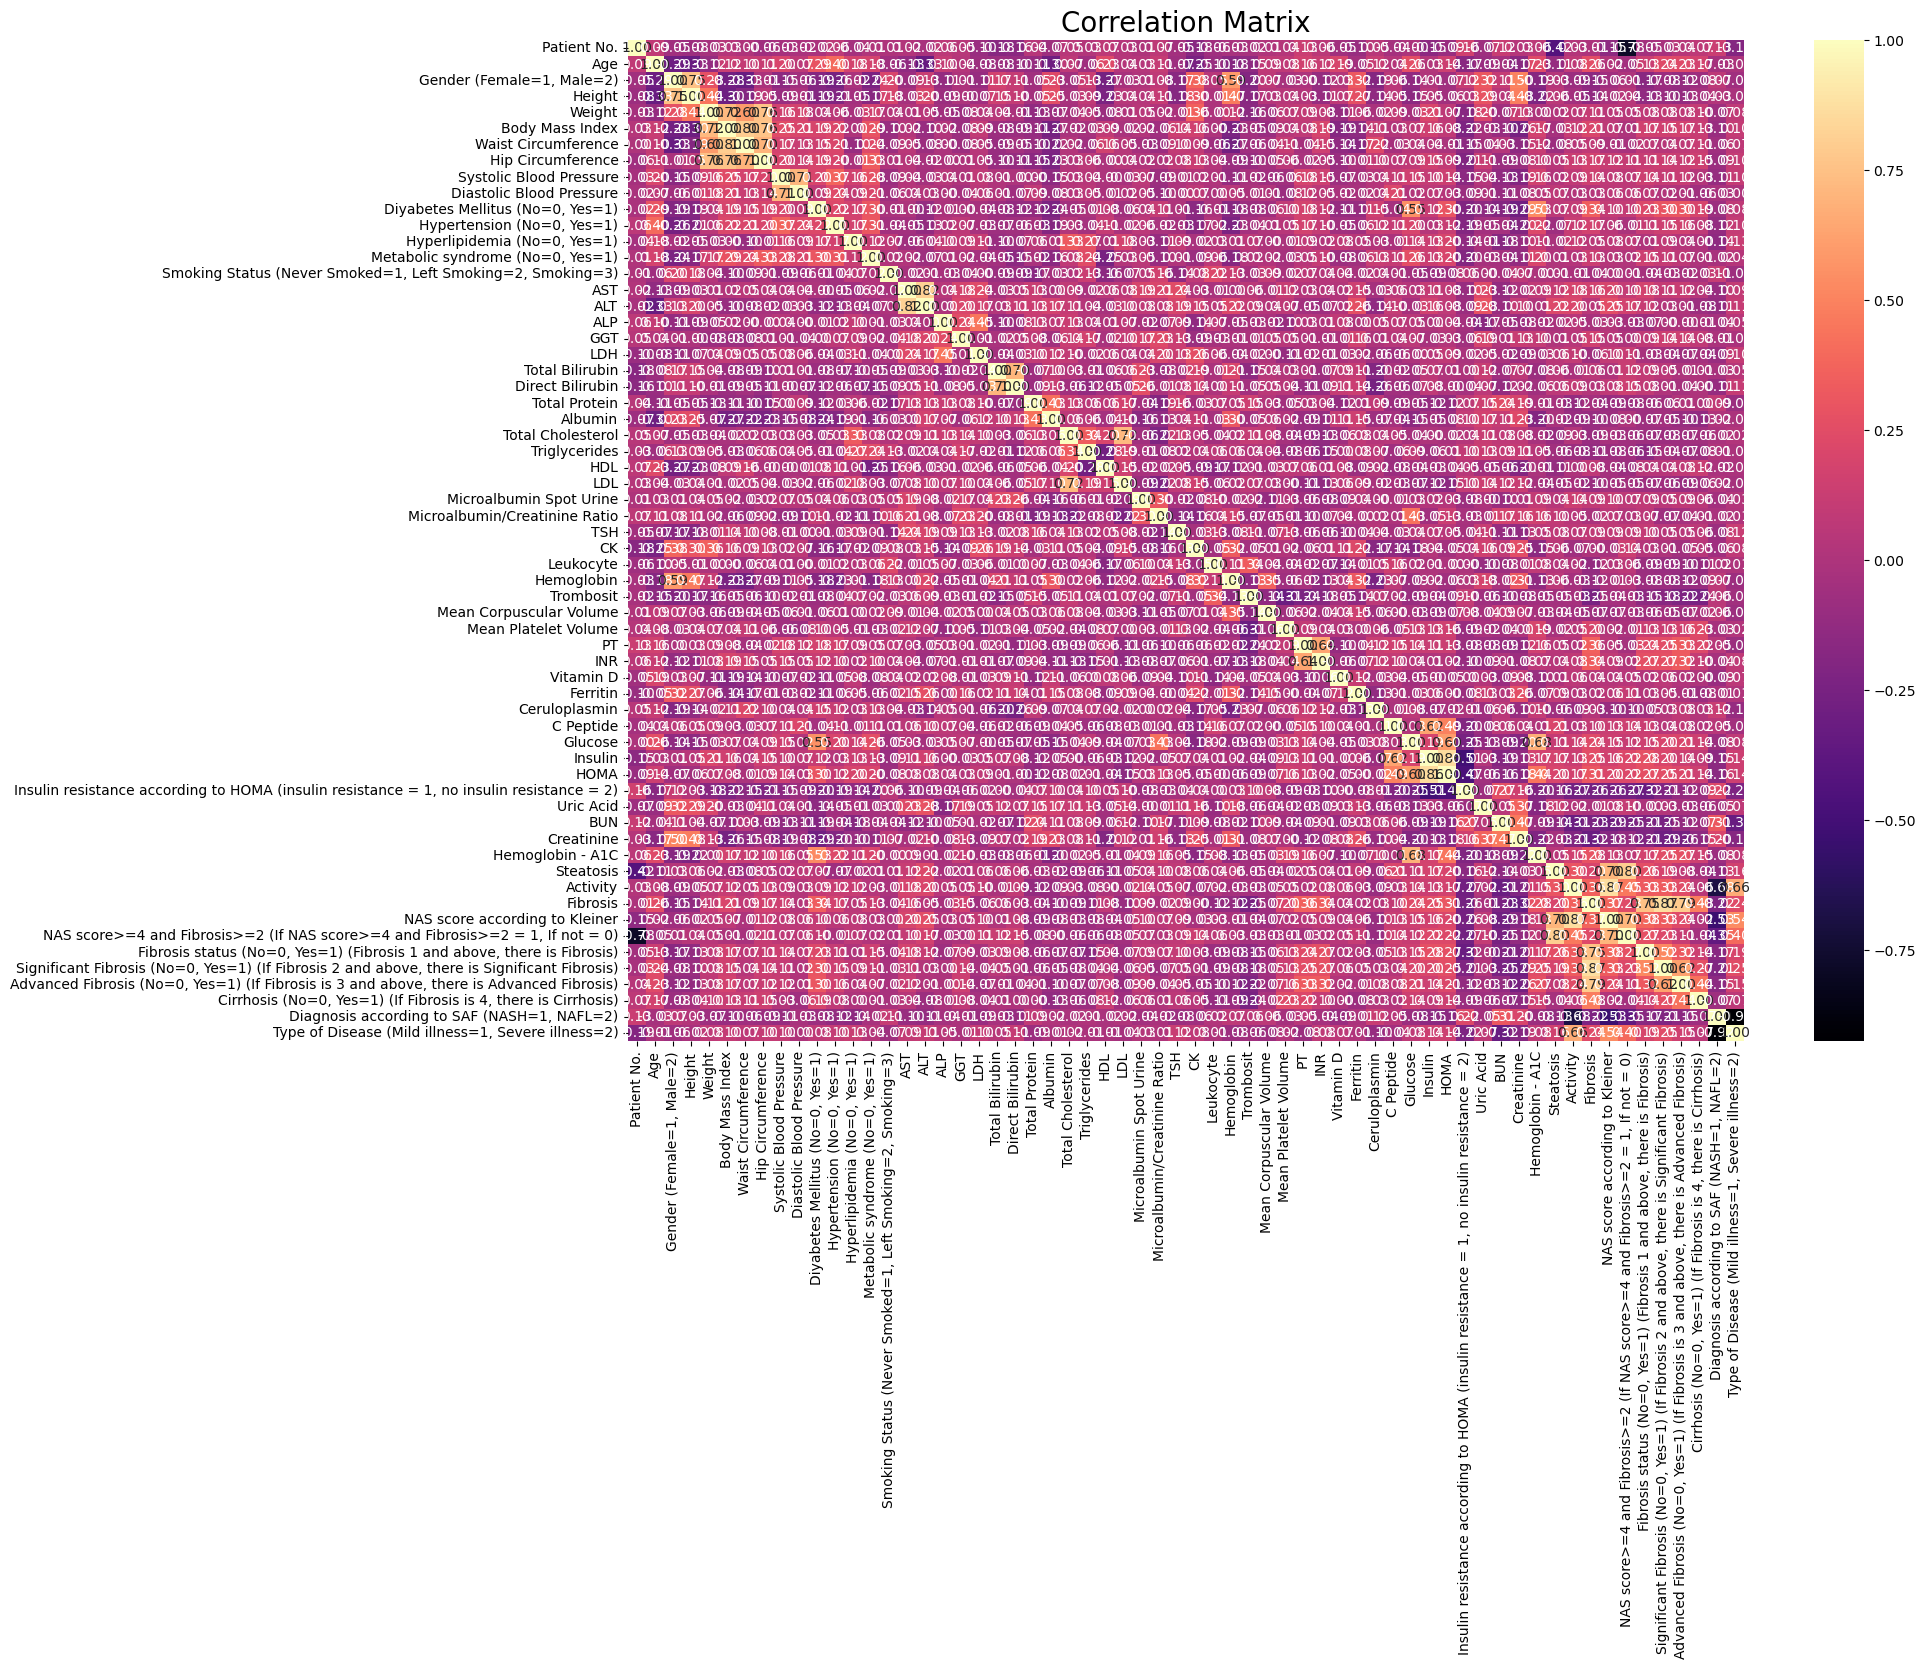

In [17]:

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax,cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [18]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ['Diyabetes Mellitus (No=0, Yes=1)',"Hypertension (No=0, Yes=1)","Hyperlipidemia (No=0, Yes=1)","Metabolic syndrome (No=0, Yes=1)","Fibrosis","NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)","Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)","Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)","Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)","Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)","Activity"])]

In [19]:
zero_columns

['Microalbumin Spot Urine']

In [20]:
for col in zero_columns:
  df[col] = np.where(df[col] == 0, np.nan,df[col])

In [21]:
# eksik değer analizi:
df.isnull().sum()

Patient No.                                                                                    0
Age                                                                                            0
Gender (Female=1, Male=2)                                                                      0
Height                                                                                         0
Weight                                                                                         0
                                                                                              ..
Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)    0
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)       0
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)                                 0
Diagnosis according to SAF (NASH=1, NAFL=2)                                                    0
Type of Disease (Mild illness=

In [22]:
def missing_values_table(dataframe, na_name=False):
 na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
 n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
 ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] + 100).sort_values(ascending=False)
 missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
 print(missing_df, end="\n")
 if na_name:
  return na_columns

In [23]:
na_columns = missing_values_table(df, na_name=True)


                                                    n_miss   ratio
Microalbumin/Creatinine Ratio                          490  100.81
CK                                                     452  100.75
C Peptide                                              438  100.72
Microalbumin Spot Urine                                424  100.70
Vitamin D                                              412  100.68
PT                                                     368  100.61
Uric Acid                                              351  100.58
Insulin                                                328  100.54
Insulin resistance according to HOMA (insulin r...     328  100.54
HOMA                                                   328  100.54
Ceruloplasmin                                          317  100.52
TSH                                                    312  100.52
INR                                                    301  100.50
BUN                                                    300  10

In [24]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [25]:
missing_vs_target(df, "Diagnosis according to SAF (NASH=1, NAFL=2)", na_columns)

                             TARGET_MEAN  Count
Waist Circumference_NA_FLAG                    
0                               1.118056    576
1                               1.000000     29


                           TARGET_MEAN  Count
Hip Circumference_NA_FLAG                    
0                             1.113712    598
1                             1.000000      7


                                                    TARGET_MEAN  Count
Smoking Status (Never Smoked=1, Left Smoking=2,...                    
0                                                      1.117851    577
1                                                      1.000000     28


             TARGET_MEAN  Count
ALP_NA_FLAG                    
0               1.112583    604
1               1.000000      1


             TARGET_MEAN  Count
GGT_NA_FLAG                    
0               1.112957    602
1               1.000000      3


             TARGET_MEAN  Count
LDH_NA_FLAG                    
0         

In [26]:
# Eksik Değerlerin Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()


In [27]:
df.isnull().sum()

Patient No.                                                                                    0
Age                                                                                            0
Gender (Female=1, Male=2)                                                                      0
Height                                                                                         0
Weight                                                                                         0
                                                                                              ..
Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)    0
Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)       0
Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)                                 0
Diagnosis according to SAF (NASH=1, NAFL=2)                                                    0
Type of Disease (Mild illness=

In [28]:
# Aykırı değer analizi
def outlier_threshold(dataframe, col_name, q1=0.05, q3=0.95):
 quartile1 = dataframe[col_name].quantile(q1)
 quartile3 = dataframe[col_name].quantile(q3)
 interquantile_range = quartile3 - quartile1
 up_limit = quartile3 + 1.5 * interquantile_range
 low_limit = quartile1 - 1.5 * interquantile_range
 return low_limit, up_limit

In [29]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [30]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_threshold(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



In [31]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)




Patient No. False
Age False
Gender (Female=1, Male=2) False
Height False
Weight False
Body Mass Index False
Waist Circumference False
Hip Circumference False
Systolic Blood Pressure False
Diastolic Blood Pressure False
Diyabetes Mellitus (No=0, Yes=1) False
Hypertension (No=0, Yes=1) False
Hyperlipidemia (No=0, Yes=1) False
Metabolic syndrome (No=0, Yes=1) False
Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3) False
AST True
ALT False
ALP True
GGT True
LDH True
Total Bilirubin True
Direct Bilirubin True
Total Protein False
Albumin False
Total Cholesterol False
Triglycerides True
HDL False
LDL True
Microalbumin Spot Urine True
Microalbumin/Creatinine Ratio True
TSH True
CK True
Leukocyte False
Hemoglobin False
Trombosit False
Mean Corpuscular Volume True
Mean Platelet Volume True
PT False
INR True
Vitamin D False
Ferritin False
Ceruloplasmin True
C Peptide False
Glucose True
Insulin False
HOMA False
Insulin resistance according to HOMA (insulin resistance = 1, no insulin resis

In [32]:
for col in df.columns:
    print(col, check_outlier(df, col))

Patient No. False
Age False
Gender (Female=1, Male=2) False
Height False
Weight False
Body Mass Index False
Waist Circumference False
Hip Circumference False
Systolic Blood Pressure False
Diastolic Blood Pressure False
Diyabetes Mellitus (No=0, Yes=1) False
Hypertension (No=0, Yes=1) False
Hyperlipidemia (No=0, Yes=1) False
Metabolic syndrome (No=0, Yes=1) False
Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3) False
AST False
ALT False
ALP False
GGT False
LDH False
Total Bilirubin False
Direct Bilirubin False
Total Protein False
Albumin False
Total Cholesterol False
Triglycerides False
HDL False
LDL False
Microalbumin Spot Urine False
Microalbumin/Creatinine Ratio False
TSH False
CK False
Leukocyte False
Hemoglobin False
Trombosit False
Mean Corpuscular Volume False
Mean Platelet Volume False
PT False
INR False
Vitamin D False
Ferritin False
Ceruloplasmin False
C Peptide False
Glucose False
Insulin False
HOMA False
Insulin resistance according to HOMA (insulin resistance = 1,

In [33]:
def label_encoder(dataframe, binary_col):
 labelencoder = labelEncoder()
 dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
 return dataframe



In [34]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
   df = label_encoder(df, col)
df.head()

Patient No.  Age  Gender (Female=1, Male=2)  Height  Weight  \
0            1   60                          1     150      80   
1            2   55                          1     154      73   
2            3   53                          2     170     101   
3            4   33                          2     175      95   
4            5   23                          2     162      68   

   Body Mass Index  Waist Circumference  Hip Circumference  \
0            35.56                119.0              104.0   
1            30.78                101.0               98.0   
2            34.95                116.0              112.0   
3            31.02                114.0              114.0   
4            25.91                101.0               97.0   

   Systolic Blood Pressure  Diastolic Blood Pressure  ...  Activity  Fibrosis  \
0                      135                        77  ...         2         1   
1                      120                        72  ...         2         0   
2                      120                        80  ...         2         3   
3                      124                        83  ...         2         1   
4                      124                        79  ...         2         0   

   NAS score according to Kleiner  \
0                               4   
1                               4   
2                               4   
3                               4   
4                               4   

   NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)  \
0                                                  1                                
1                                                  1                                
2                                                  1                                
3                                                  1                                
4                                                  1                                

   Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)  \
0                                                  1                         
1                                                  0                         
2                                                  1                         
3                                                  1                         
4                                                  0                         

   Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)  \
0                                                  0                                             
1                                                  0                                             
2                                                  1                                             
3                                                  0                                             
4                                                  0                                             

   Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)  \
0                                                  0                                          
1                                                  0                                          
2                                                  1                                          
3                                                  0                                          
4                                                  0                                          

   Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                     

In [35]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [36]:

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [37]:
df.head()

Patient No.  Age  Height  Weight  Body Mass Index  Waist Circumference  \
0            1   60     150      80            35.56                119.0   
1            2   55     154      73            30.78                101.0   
2            3   53     170     101            34.95                116.0   
3            4   33     175      95            31.02                114.0   
4            5   23     162      68            25.91                101.0   

   Hip Circumference  Systolic Blood Pressure  Diastolic Blood Pressure   AST  \
0              104.0                      135                        77  27.0   
1               98.0                      120                        72  17.0   
2              112.0                      120                        80  51.0   
3              114.0                      124                        83  31.0   
4               97.0                      124                        79  32.0   

   ...  NAS score according to Kleiner_5  NAS score according to Kleiner_6  \
0  ...                                 0                                 0   
1  ...                                 0                                 0   
2  ...                                 0                                 0   
3  ...                                 0                                 0   
4  ...                                 0                                 0   

   NAS score according to Kleiner_7  NAS score according to Kleiner_8  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)_1  \
0                                                  1                                  
1                                                  1                                  
2                                                  1                                  
3                                                  1                                  
4                                                  1                                  

   Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)_1  \
0                                                  1                           
1                                                  0                           
2                                                  1                           
3                                                  1                           
4                                                  0                           

   Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)_1  \
0                                                  0                                               
1                                                  0                                               
2                                                  1                                               
3                                                  0                                               
4                                                  0                                               

   Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)_1  \
0                                                  0                                            
1                                                  0                                            
2                                                  1                                            
3                                                  0                                            
4                                                  0   

In [38]:

#STANDARTLAŞTIRMA
##################################

num_cols

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


df.shape

(605, 75)

In [39]:
df.head()

Patient No.       Age    Height    Weight  Body Mass Index  \
0    -1.729190  1.287682 -1.492133 -0.445686         0.723409   
1    -1.723464  0.817640 -1.088584 -0.932904        -0.213363   
2    -1.717739  0.629623  0.525615  1.015967         0.603863   
3    -1.712013 -1.250545  1.030052  0.598352        -0.166328   
4    -1.706287 -2.190629 -0.281484 -1.280917        -1.167772   

   Waist Circumference  Hip Circumference  Systolic Blood Pressure  \
0             0.903537          -0.029490                 0.504769   
1            -0.797857          -0.607687                -0.475497   
2             0.619972           0.741439                -0.475497   
3             0.430928           0.934172                -0.214092   
4            -0.797857          -0.704053                -0.214092   

   Diastolic Blood Pressure       AST  ...  NAS score according to Kleiner_5  \
0                 -0.545937 -0.751291  ...                                 0   
1                 -1.049277 -1.100774  ...                                 0   
2                 -0.243933  0.087469  ...                                 0   
3                  0.058071 -0.611498  ...                                 0   
4                 -0.344601 -0.576549  ...                                 0   

   NAS score according to Kleiner_6  NAS score according to Kleiner_7  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   NAS score according to Kleiner_8  \
0                                 0   
1                                 0   
2                                 0   
3                                 0   
4                                 0   

   NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)_1  \
0                                                  1                                  
1                                                  1                                  
2                                                  1                                  
3                                                  1                                  
4                                                  1                                  

   Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)_1  \
0                                                  1                           
1                                                  0                           
2                                                  1                           
3                                                  1                           
4                                                  0                           

   Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)_1  \
0                                                  0                                               
1                                                  0                                               
2                                                  1                                               
3                                                  0                                               
4                                                  0                                               

   Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)_1  \
0                                                  0                                            
1                                                  0                                            
2                                                  1                                            
3                                          

In [40]:
df["Diagnosis according to SAF (NASH=1, NAFL=2)_2"].head

<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
600    0
601    0
602    0
603    0
604    0
Name: Diagnosis according to SAF (NASH=1, NAFL=2)_2, Length: 605, dtype: uint8>

In [41]:
df["Diagnosis according to SAF (NASH=1, NAFL=2)_2"].isnull().sum().any()

False

In [55]:
# Tüm kategorik değişkenlerle istatistiksel ilişkiyi bulmak için bir fonksiyon tanımlama
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    #Son seçilen tahmincilerin boş bir listesini oluşturmak
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
       # ANOVA P-Değeri <0,05 ise, bu H0'ı reddettiğimiz anlamına gelir
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [56]:
# Hangi kategorik değişkenlerin hedefle ilişkili olduğunu kontrol etmek için işlevi çağırma
ContinuousVariables= df.columns[df.nunique() >= 4]
FunctionAnova(inpData=df, TargetVariable="Diagnosis according to SAF (NASH=1, NAFL=2)_2", ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

Patient No. is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.0009134116911245091
Age is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.42136109287573675
Height is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.49805278108975726
Weight is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.0916799691319916
Body Mass Index is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.017953919115727173
Waist Circumference is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.13104425524419144
Hip Circumference is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.030370858399728477
Systolic Blood Pressure is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.007463604853226319
Diastolic Blood Pressure is NOT correlated with Diagnosis according to SAF (

['Patient No.',
 'Body Mass Index',
 'Hip Circumference',
 'Systolic Blood Pressure',
 'AST',
 'ALT',
 'LDH',
 'Direct Bilirubin',
 'Total Protein',
 'Ceruloplasmin',
 'Glucose',
 'Insulin',
 'HOMA',
 'BUN',
 'Creatinine']

In [57]:
# Tüm kategorik değişkenlerin Hedef değişkenle korelasyonunu bulmak için bir işlev yazma
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency
    
    # Son seçilen tahmincilerin boş bir listesini oluşturma
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        # ChiSq P-Değeri <0,05 ise, bu H0'ı reddettiğimiz anlamına gelir
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

In [58]:
CategoricalVariables=df.columns[df.nunique() <= 4]


FunctionChisq(inpData=df, 
              TargetVariable="Diagnosis according to SAF (NASH=1, NAFL=2)_2",
              CategoricalVariablesList= CategoricalVariables)

Gender (Female=1, Male=2)_2 is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.09772244025720045
Diyabetes Mellitus (No=0, Yes=1)_1 is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.07058565400477153
Hypertension (No=0, Yes=1)_1 is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.004497555940545689
Hyperlipidemia (No=0, Yes=1)_1 is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.0007307139520586225
Metabolic syndrome (No=0, Yes=1)_1 is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.6742763707447966
Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)_2.0 is NOT correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.9250623407726821
Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)_3.0 is correlated with Diagnosis according to SAF (NASH=1, NAFL=2)_2 | P-Value: 0.007705702905740602
Insulin resistance accordi

['Hypertension (No=0, Yes=1)_1',
 'Hyperlipidemia (No=0, Yes=1)_1',
 'Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)_3.0',
 'Insulin resistance according to HOMA (insulin resistance = 1, no insulin resistance = 2)_2.0',
 'Activity_1',
 'Activity_2',
 'Activity_3',
 'Activity_4',
 'Fibrosis_2',
 'Fibrosis_3',
 'NAS score according to Kleiner_2',
 'NAS score according to Kleiner_3',
 'NAS score according to Kleiner_5',
 'NAS score according to Kleiner_6',
 'NAS score according to Kleiner_7',
 'NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)_1',
 'Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)_1',
 'Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)_1',
 'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)_1',
 'Diagnosis according to SAF (NASH=1, NAFL=2)_2',
 'Type of Disease (Mild illness=1, Severe illness=2)_2']

In [46]:
# Sayısal sütunlar için eksik verileri medyan ile doldurma
df = df.apply(lambda x: x.fillna(x.median()) if x.dtype in ['float64', 'int64'] else x)

# Veri setindeki hala eksik veri var mı kontrol et
total_missing_percentage = (df.isna().sum().sum() / df.size) * 100
print(f"Veri setindeki genel eksik veri oranı: {total_missing_percentage:.2f}%")

Veri setindeki genel eksik veri oranı: 0.00%


In [47]:
####chi2 ve anovadan çıkan değerler ile en etkili featuresları kullanmak için bir tahminci listesi yapalım

predictors=[
 'Body Mass Index',
 'Hip Circumference',
 'Systolic Blood Pressure',
 'AST',
 'ALT',
 'LDH',
 'Direct Bilirubin',
 'Total Protein',
 'TSH',
 'Mean Corpuscular Volume',
 'Glucose',
 'Insulin',
 'HOMA',
 'BUN',
 'Creatinine', 
 'Hypertension (No=0, Yes=1)_1',
 'Hyperlipidemia (No=0, Yes=1)_1',
 'Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)_3.0',
 'Insulin resistance according to HOMA (insulin resistance = 1, no insulin resistance = 2)_2.0',
 'Activity_1',
 'Activity_2',
 'Activity_3',
 'Activity_4',
 'Fibrosis_2',
 'Fibrosis_3',
 'NAS score according to Kleiner_2',
 'NAS score according to Kleiner_3',
 'NAS score according to Kleiner_5',
 'NAS score according to Kleiner_6',
 'NAS score according to Kleiner_7',
 'NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)_1',
 'Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)_1',
 'Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)_1',
 'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)_1',
 
]

y = df["Diagnosis according to SAF (NASH=1, NAFL=2)_2"]
X = df[predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


In [48]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# ceza='l1' veya C=1 parametresini seçin

# çözücü 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga için farklı değerler seçin'
clf = LogisticRegression(C=1,penalty='l2', solver='newton-cg')

# Lojistik regresyonun tüm parametrelerinin yazdırılması

# print(clf)

# Eğitim Verileri üzerinde model oluşturma
LOG=clf.fit(X_train,y_train)
prediction=LOG.predict(X_test)

# Test Verilerinde doğruluğun ölçülmesi
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Modelin Genel Doğruluğunu Yazdırma
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Sklearn'den çapraz doğrulama işlevini içe aktarma
from sklearn.model_selection import cross_val_score

# Belirli bir algoritmada 10 Kat Çapraz doğrulamayı çalıştırma

# Tam veri X ve y iletmek çünkü K-kat verileri bölecek ve otomatik olarak tren/test seçecek
Accuracy_Values=cross_val_score(LOG, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       152
           1       1.00      0.93      0.97        30

    accuracy                           0.99       182
   macro avg       0.99      0.97      0.98       182
weighted avg       0.99      0.99      0.99       182

[[152   0]
 [  2  28]]
Accuracy of the model on Testing Sample Data: 0.99

Accuracy values for 10-fold Cross Validation:
 [0.96477894 1.         0.89707755 0.86734254 1.         1.
 1.         0.98277019 1.         1.        ]

Final Average Accuracy of the model: 0.97


RandomForestClassifier(max_depth=10)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       152
           1       1.00      0.90      0.95        30

    accuracy                           0.98       182
   macro avg       0.99      0.95      0.97       182
weighted avg       0.98      0.98      0.98       182

[[152   0]
 [  3  27]]
Accuracy of the model on Testing Sample Data: 0.98

Accuracy values for 10-fold Cross Validation:
 [0.96477894 1.         0.89707755 0.86734254 1.         1.
 1.         1.         1.         1.        ]

Final Average Accuracy of the model: 0.97


<Axes: >

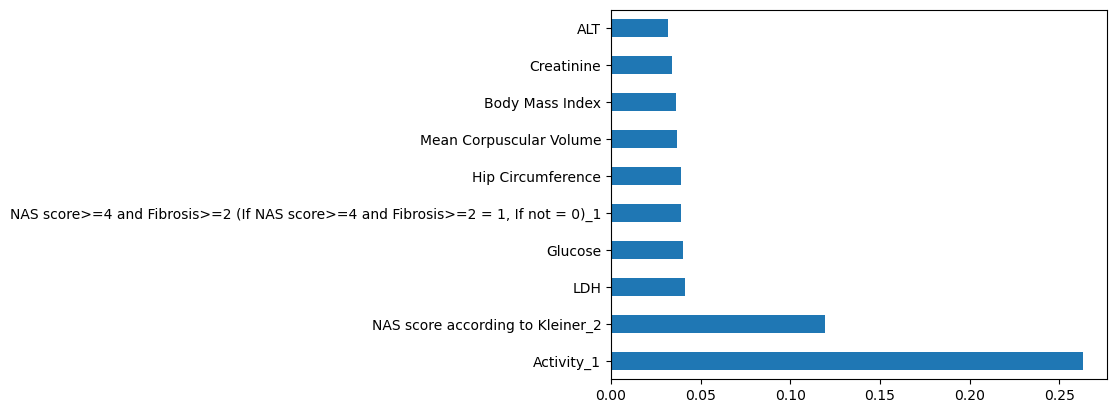

In [49]:
# Random Forest (Bagging of multiple Decision Trees)
from sklearn.ensemble import RandomForestClassifier
# Choose various values of max_depth, n_estimators and criterion for tuning the model
clf = RandomForestClassifier(max_depth=10, n_estimators=100,criterion='gini')


# Rastgele Orman'ın tüm parametrelerini yazdırma
print(clf)

# Eğitim Verileri üzerinde model oluşturma
RF=clf.fit(X_train,y_train)
prediction=RF.predict(X_test)

#Test Verilerinde doğruluk ölçümü
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Modelin Genel Doğruluğunu Yazdırma
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Sklearn'den çapraz doğrulama işlevini içe aktarma
from sklearn.model_selection import cross_val_score

# Belirli bir algoritmada 10 Kat Çapraz doğrulamayı çalıştırma

# Tam veri X ve y iletmek çünkü K-kat verileri bölecek ve otomatik olarak tren/test seçecek
Accuracy_Values=cross_val_score(RF, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


# En önemli 10 sütun için özellik öneminin çizilmesi
%matplotlib inline
feature_importances = pd.Series(RF.feature_importances_, index=predictors)
feature_importances.nlargest(10).plot(kind='barh')

In [50]:

# Support Vector Machines(SVM)
from sklearn import svm
clf = svm.SVC(C=2, kernel='rbf', gamma=0.1)

# Printing all the parameters of SVM
print(clf)

# Creating the model on Training Data
SVM=clf.fit(X_train,y_train)
prediction=SVM.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(SVM, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


# Plotting the feature importance for Top 10 most important columns
# The built in attribute SVM.coef_ works only for linear kernel
%matplotlib inline
#feature_importances = pd.Series(SVM.coef_[0], index=Predictors)
#feature_importances.nlargest(10).plot(kind='barh')



SVC(C=2, gamma=0.1)
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       152
           1       1.00      0.67      0.80        30

    accuracy                           0.95       182
   macro avg       0.97      0.83      0.88       182
weighted avg       0.95      0.95      0.94       182

[[152   0]
 [ 10  20]]
Accuracy of the model on Testing Sample Data: 0.94

Accuracy values for 10-fold Cross Validation:
 [0.94477786 0.92248244 0.83136137 0.86734254 1.         1.
 1.         0.96419753 1.         0.92121212]

Final Average Accuracy of the model: 0.95


DecisionTreeClassifier(max_depth=4)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       152
           1       1.00      0.93      0.97        30

    accuracy                           0.99       182
   macro avg       0.99      0.97      0.98       182
weighted avg       0.99      0.99      0.99       182

[[152   0]
 [  2  28]]
Accuracy of the model on Testing Sample Data: 0.99

Accuracy values for 10-fold Cross Validation:
 [0.94915372 1.         0.89707755 0.86734254 1.         0.98389648
 1.         1.         1.         1.        ]

Final Average Accuracy of the model: 0.97


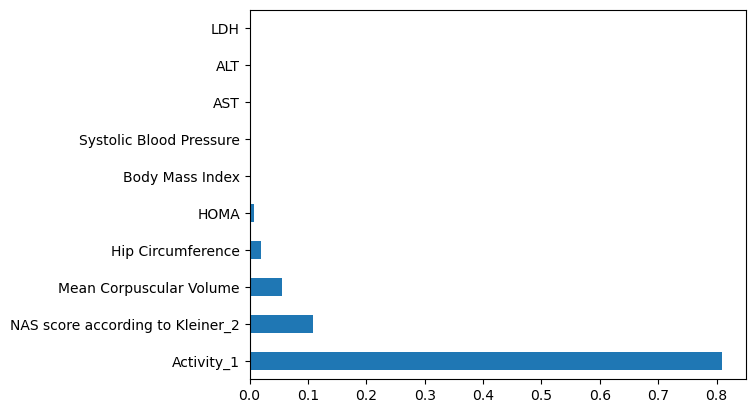

In [51]:
#Decision Trees
from sklearn import tree
# farklı ayarlanabilir hiper parametreler arasından seçim yapın

# Modeli ayarlamak için çeşitli max_depth değerlerini ve kriterini seçin
clf = tree.DecisionTreeClassifier(max_depth=4,criterion='gini')

# Karar Ağaçlarının tüm parametrelerinin yazdırılması
print(clf)

# Eğitim Verileri üzerinde model oluşturma
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)

# Test Verilerinde doğruluğun ölçülmesi
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Modelin Genel Doğruluğunu Yazdırma
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
# En önemli 10 sütun için özellik öneminin çizilmesi
%matplotlib inline
feature_importances = pd.Series(DTree.feature_importances_, index=predictors)
feature_importances.nlargest(10).plot(kind='barh')

# Sklearn'den çapraz doğrulama işlevini içe aktarma
from sklearn.model_selection import cross_val_score

# Belirli bir algoritmada 10 Kat Çapraz doğrulamayı çalıştırma

# Tam veri X ve y iletmek çünkü K-kat verileri bölecek ve otomatik olarak tren/test seçecek
Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.01, n_estimators=200)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       152
           1       0.94      0.97      0.95        30

    accuracy                           0.98       182
   macro avg       0.96      0.98      0.97       182
weighted avg       0.98      0.98      0.98       182

[[150   2]
 [  1  29]]
Accuracy of the model on Testing Sample Data: 0.98

Accuracy values for 10-fold Cross Validation:
 [0.96477894 1.         0.89707755 0.88372365 0.96895298 0.96873315
 1.         0.98380952 1.         0.71176471]

Final Average Accuracy of the model: 0.94


<Axes: >

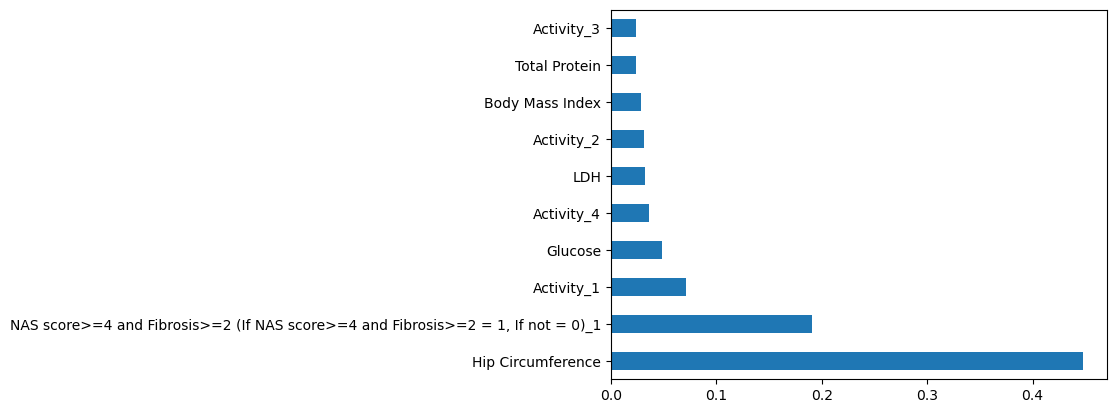

In [52]:
# Adaboost 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Zayıf öğrenci olarak 1 düzeyli Karar Ağacı'nı seçme

# Modeli ayarlamak için farklı max_depth, n_estimators ve learning_rate değerlerini seçin
DTC=DecisionTreeClassifier(max_depth=4)
clf = AdaBoostClassifier(n_estimators=200, base_estimator=DTC ,learning_rate=0.01)

# Adaboost'un tüm parametrelerinin yazdırılması
print(clf)
# Eğitim Verileri üzerinde model oluşturma
AB=clf.fit(X_train,y_train)
prediction=AB.predict(X_test)
# Test Verilerinde doğruluğun ölçülmesi
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Modelin Genel Doğruluğunu Yazdırma
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
# Sklearn'den çapraz doğrulama işlevini içe aktarma
from sklearn.model_selection import cross_val_score

# Belirli bir algoritmada 10 Kat Çapraz doğrulamayı çalıştırma

# Tam veri X ve y iletmek çünkü K-kat verileri bölecek ve otomatik olarak tren/test seçecek
Accuracy_Values=cross_val_score(AB, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

# En önemli 10 sütun için özellik öneminin çizilmesi
%matplotlib inline
feature_importances = pd.Series(AB.feature_importances_, index=predictors)
feature_importances.nlargest(10).plot(kind='barh')

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       152
           1       1.00      0.90      0.95        30

    accuracy                           0.98       182
   macro avg       0.99

<Axes: >

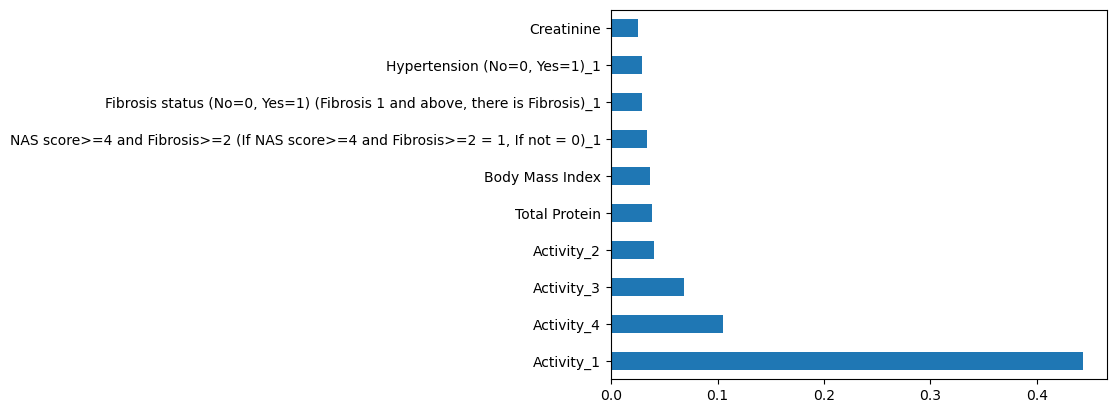

In [53]:
# Xtreme Gradient Boosting (XGBoost)
from xgboost import XGBClassifier
clf=XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, objective='binary:logistic', booster='gbtree')

##beklenen değer 0==>1 olması gerekli bu yüzden 1==>2 değerinden 1 çıkartarak gerekli aralığa alıyoruz
y = df["Diagnosis according to SAF (NASH=1, NAFL=2)_2"]
X = df[predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)





# XGBoost'un tüm parametrelerini yazdırma
print(clf)

# Eğitim Verileri üzerinde model oluşturma
XGB=clf.fit(X_train,y_train)
prediction=XGB.predict(X_test)

#Test Verilerinde doğruluk ölçümü
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Modelin Genel Doğruluğunu Yazdırma
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Sklearn'den çapraz doğrulama işlevini içe aktarma
from sklearn.model_selection import cross_val_score

#Belirli bir algoritmada 10 Kat Çapraz doğrulama çalıştırma

# Tam veri X ve y iletmek çünkü K-kat verileri bölecek ve otomatik olarak tren/test seçecek
Accuracy_Values=cross_val_score(XGB, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

#En önemli 10 sütun için özellik öneminin çizilmesi
%matplotlib inline
feature_importances = pd.Series(XGB.feature_importances_, index=predictors)
feature_importances.nlargest(10).plot(kind='barh')
